# Introduction

### Define global variables, classifiers and folds.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
import plotly.express as px

%matplotlib inline
np.random.seed(0)
random_state = 42

In [2]:
n_PCs = [10, 20, 25, 30, 35, 40, 50, 100, 500]
n_top_features = [30, 40, 50, 100, 150, 200, 250, 500]
n_neighbors = [1, 2, 3, 5, 8, 10, 20, 50]
test_sizes = [0.2, 0.4, 0.7]
mislabel_percentages = [0, 0.2, 0.4, 0.6]


stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

knn = KNeighborsClassifier(weights='uniform')
logistic = LogisticRegression(class_weight='balanced', C=1e-10, random_state=random_state)
rf = RandomForestClassifier(n_estimators=50,  class_weight='balanced', random_state=random_state)
mlp = MLPClassifier(random_state=random_state, hidden_layer_sizes=(50, 50))
dummy = DummyClassifier(strategy='most_frequent')

### Read dataset. Define noise and mislabeling.

In [3]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

Y['x'].unique()
# assign a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

In [4]:
def Y_train_mislabeled(Y_train, percentage):
    ''' Return Y_train mislabeled. '''
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
        
    return Y_train

In [5]:
def splits(gaussian_noise_factor=0, test_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise

    return X_train_noisy, X_test, Y_train, Y_test

### Exploratory data analysis

In [6]:
X.head()

V1        V2        V3        V4        V5        V6        V7  \
1 -1.168003  1.261756 -1.534537 -0.156028 -0.700344  3.985627  2.432774   
2 -3.272103 -0.269244 -1.534537 -0.679228 -0.947544  0.794827  0.067374   
3 -0.861503 -0.189544 -1.534537  0.010572 -0.268144  1.808827  1.273274   
4 -0.595803 -0.580044 -1.534537 -0.107828 -0.475644  0.738027 -1.945726   
5  1.336097  0.360556 -1.534537 -0.097728  0.359656 -0.940173  0.378774   

         V8        V9       V10  ...     V1991     V1992     V1993     V1994  \
1  0.767859  1.225563 -0.198581  ... -0.015099 -0.217915  0.123574 -3.209894   
2  0.033459 -0.010137 -0.198581  ...  0.285601 -0.155615  1.044074 -3.209894   
3 -0.501841  0.753163 -0.198581  ... -1.816599 -0.217015  0.023974 -3.209894   
4  0.476859 -0.010137 -0.198581  ... -0.532399 -0.402215 -0.410726 -3.209894   
5 -0.271741 -0.010137 -0.198581  ... -0.894799  0.043385  0.273874 -0.747594   

     V1995     V1996   V1997     V1998     V1999    V2000  
1 -1.26123 -1.676247 -0.8625 -1.103947 -1.109631  0.43515  
2 -2.37073  1.973753 -1.9055 -1.103947 -1.109631  0.89295  
3 -0.27183  0.245753 -1.2135 -1.103947 -1.109631 -0.45655  
4  0.36967  1.586153 -0.5700 -1.103947  1.215569  0.45415  
5 -0.46893 -0.481547  0.6180 -1.103947 -0.392031 -0.88775  

[5 rows x 2000 columns]

In [7]:
# plot the first 3 genes to see if there is a clear separation between the classes
fig = px.scatter_3d(X, x='V1', y='V2', z='V3',
                    title='Interactive 3D Scatter Plot of Gene Interactions',
                    labels={'Gene1': 'Gene1 Expression', 'Gene2': 'Gene2 Expression', 'Gene3': 'Gene3 Expression'},
                    width=800, height=600)

fig.update_layout(scene=dict(
                    xaxis_title='Gene1 Expression',
                    yaxis_title='Gene2 Expression',
                    zaxis_title='Gene3 Expression'),
                  margin=dict(l=0, r=0, b=0, t=30))

fig.show()

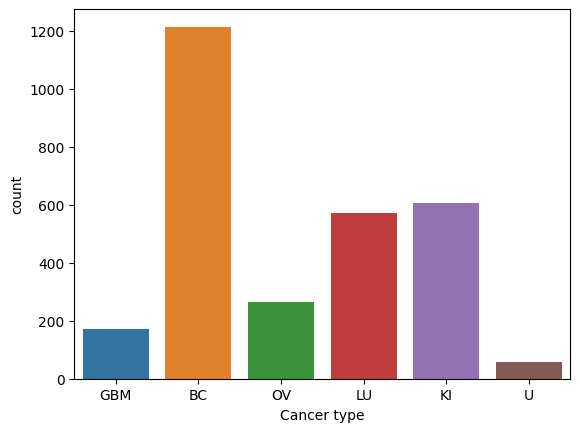

In [8]:
# hist of the class labels
sns.countplot(data=Y, x='x')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['GBM', 'BC', 'OV', 'LU', 'KI', 'U'])
plt.xlabel('Cancer type')
plt.title('Classes Frequency')
plt.show()

In [9]:
def pca_ratios(X_train, test_size):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    pca = PCA()  
    pca.fit_transform(X_scaled)

    explained_variance_ratios = pca.explained_variance_ratio_
    cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

    n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.8]) + 1
    print(f"Number of components needed to explain 80% variance: {n_components_80}")
    n_components_50 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.5]) + 1
    print(f"Number of components needed to explain 50% variance: {n_components_50}")

    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratios, label='Individual explained variance')
    plt.plot(cumulative_variance_ratios, label='Cumulative explained variance')
    plt.title(f"PCA Explained Variance (train size = {1-test_size})")
    plt.xlabel('Principal components index')
    plt.ylabel('Explained variance ratio')
    plt.grid(True)
    plt.savefig(f"img/test_{test_size}_pca_ratios.png")
    plt.show()

In [10]:
# Create a VarianceThreshold object with a threshold of 0
vt = VarianceThreshold(threshold=0)

# Fit and transform the data to remove features with 0 variance
X_vt = vt.fit_transform(X)

# Get the number of features after filtering
num_features_after = X_vt.shape[1]

print(f"Number of features after applying VarianceThreshold: {num_features_after}")
print(f"Number of features with variance 0: {X.shape[1]-num_features_after}")

Number of features after applying VarianceThreshold: 1983
Number of features with variance 0: 17


# Setup

### Part 1 - task 1

In [11]:
# setup and function for part 1 - task 1
parameters_1 = {
    'pca__n_components': n_PCs,
    'estimator__n_neighbors': n_neighbors
}

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('estimator', knn)
])

def grid_search_1(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_1, parameters_1, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print('grid_search.best_params_: ', grid_search.best_params_)
    print('grid_search.best_score_: ', grid_search.best_score_)    
    
    return grid_search

def classification_report_1(X_test, Y_test, grid_search_1):
    Y_test_pred_1 = grid_search_1.predict(X_test)
    best_params_1 = grid_search_1.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_1['estimator__n_neighbors'], " neighbors and ",
        best_params_1['pca__n_components'], "principal components:\n\n",
        classification_report_1(Y_test, Y_test_pred_1))

In [12]:
def plot_accuracy_vs_nr_neighbors_1(grid_search_1, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    components = [str(params[i]['pca__n_components']) for i in range(len(params))]
    
    plt.figure(figsize=(10, 6))
    for comp in set(components):
        indices = [i for i, c in enumerate(components) if c == comp]
        plt.plot(np.array(neighbors)[indices], np.array(mean_test_scores)[indices], marker='o', label=f'{comp} PCs', alpha=0.8)

    plt.legend(title="Nr. PCs")
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Neighbors with PCA Components (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_neighbors_1.png")
    plt.show()

def plot_accuracy_vs_nr_pcs_1(grid_search_1, noise_factor, mislabel_percentage, test_size):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [str(params[i]['estimator__n_neighbors']) for i in range(len(params))]
    components = [params[i]['pca__n_components'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    for neig in set(neighbors):
        indices = [i for i, c in enumerate(neighbors) if c == neig]
        plt.plot(np.array(components)[indices], np.array(mean_test_scores)[indices], marker='o', label=f'{neig} Neighbors', alpha=0.8)
        
    plt.legend(title="Number of Neighbors")
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Selection of of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_PCs, [str(tick) for tick in n_PCs])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_pcs_1.png")
    plt.show()

In [13]:
parameters_2 = {
    'kbest__k': n_top_features,
    'estimator__n_neighbors': n_neighbors,
    'kbest__score_func': [f_classif]
}

pipeline_2 = Pipeline([
    ('th', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif)),
    ('estimator', knn)
])

def grid_search_2(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_2, parameters_2, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print('grid_search.best_params_: ', grid_search.best_params_)
    print('grid_search.best_score_: ', grid_search.best_score_)
    
    return grid_search

def classification_report_2(X_test, Y_test, grid_search_2):
    Y_test_pred_2 = grid_search_2.predict(X_test)
    best_params_2 = grid_search_2.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_2['estimator__n_neighbors'], " neighbors and ",
        best_params_2['kbest__k'], "top features:\n\n",
        classification_report_1(Y_test, Y_test_pred_2))

In [14]:
def plot_accuracy_vs_nr_neighbors_2(grid_search_2, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    features = [str(params[i]['kbest__k']) for i in range(len(params))]
    
    # Plot initialization
    plt.figure(figsize=(10, 6))
    # plt.scatter(neighbors, mean_test_scores, c=features, alpha=0.8)
    for feat in set(features):
        indices = [i for i, c in enumerate(features) if c == feat]
        plt.plot(np.array(neighbors)[indices], np.array(mean_test_scores)[indices],
                 marker='o', label=f'{feat} Features', alpha=0.8)

    # plt.colorbar(label='Number of Features')
    plt.legend(title="Nr. Features")
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Neighbors with Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_neighbors_2.png")
    plt.show()

def plot_accuracy_vs_nr_features_2(grid_search_2, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [str(params[i]['estimator__n_neighbors']) for i in range(len(params))]
    features = [params[i]['kbest__k'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    #plt.scatter(features, mean_test_scores, c=neighbors, alpha=0.8)
    for neig in set(neighbors):
        indices = [i for i, c in enumerate(neighbors) if c == neig]
        plt.plot(np.array(features)[indices], np.array(mean_test_scores)[indices],
                 marker='o', label=f'{neig} Neighbors', alpha=0.8)

    # plt.colorbar(label='Number of Neighbors')
    plt.legend(title="Number of Neighbors")
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_top_features, [str(tick) for tick in n_top_features])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_features_1.png")
    plt.show()

### Part 1 - task 3

In [15]:
### Original training set.

def train_test(X_train, Y_train, X_test, Y_test, model=None, parameters=None):
    ''' Give model's name, train and predict.
        Get train accuracy and test accuracy.
        Get train and test predictions.'''
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', dummy)])
    if model is not None:
        pipeline.set_params(classifier=model)
             
    if parameters is not None:
        pipeline.set_params(**parameters)
        
    pipeline.fit(X_train, np.ravel(Y_train))
    Y_test_pred = pipeline.predict(X_test)
    Y_train_pred = pipeline.predict(X_train)
    train_score = balanced_accuracy_score(Y_train, Y_train_pred)
    test_score = balanced_accuracy_score(Y_test, Y_test_pred)

    return pipeline.named_steps['classifier'], train_score, test_score, Y_train_pred, Y_test_pred

def scores_0(X_train, Y_train, X_test, Y_test):

    best_train_score = 0
    scores = []

    for k in n_neighbors:
        _, train_score, test_score, _, _= train_test(X_train, Y_train, X_test, Y_test, model=knn, parameters={'classifier__n_neighbors': k})
        if  train_score > best_train_score:
            best_train_score = train_score
            best_train_k = k
            test_score_for_best_k = test_score
        
        scores.append({'k': k, 'train_score': train_score, 'test_score': test_score})
    
    print('Best training k:', best_train_k)
    print('Best training score:', best_train_score)
    
    return scores, best_train_score, best_train_k, test_score_for_best_k

def optimism_0(scores_0_res, noise_factor, mislabel_percentage, test_size):
    train_scores_1 = [score['train_score'] for score in scores_0_res]
    test_scores_1 = [score['test_score'] for score in scores_0_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_1, marker='o', label='train score')
    plt.plot(n_neighbors, test_scores_1, marker='x', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Original Train Set (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_0.png")
    plt.show()

In [16]:
### PCA

# def scores_fixed_pca_1(grid_search_1_res):
#     opt_scores_fixed_1 = []

#     # best number of components in general
#     opt_nr_pca = grid_search_1_res.best_params_['pca__n_components']
#     pipeline_1.set_params(pca__n_components=opt_nr_pca)
#     for k in n_neighbors:
#         pipeline_1.set_params(pca__n_components=opt_nr_pca, estimator__n_neighbors=k)
#         pipeline_1.fit(X_train, np.ravel(Y_train))
#         Y_test_pred = pipeline_1.predict(X_test)
        
#         cv_score = grid_search_1_res.cv_results_['mean_test_score'][idx]
#         test_score = balanced_accuracy_score(Y_test, Y_test_pred)

#         opt_scores_fixed_1.append({'k': k, 'pca__n_components': opt_nr_pca, 'cv_score': cv_score, 'test_score': test_score})
#         print(f"For k={k} and PCA components={opt_nr_pca}, CV Score: {cv_score}, Test Score: {test_score}")
        
#     print(opt_scores_fixed_1)
#     return opt_scores_fixed_1

def scores_1(grid_search_1_res, X_train, Y_train, X_test, Y_test):
    opt_scores_1 = []

    print("\n\n ALL CV SCORES\n\n", grid_search_1_res.cv_results_['mean_test_score'])

    for k in n_neighbors:
        # best score for current k
        idx = np.argmax([grid_search_1_res.cv_results_['mean_test_score'][i] for i, params in enumerate(grid_search_1_res.cv_results_['params']) if params['estimator__n_neighbors'] == k])
        best_nr_pca_components = grid_search_1_res.cv_results_['params'][idx]['pca__n_components']
        
        # set parameters for the best nr of PC for current k
        pipeline_1.set_params(pca__n_components=best_nr_pca_components, estimator__n_neighbors=k)
        pipeline_1.fit(X_train, np.ravel(Y_train))

        Y_train_pred = pipeline_1.predict(X_train)
        Y_test_pred = pipeline_1.predict(X_test)
        
        cv_score = grid_search_1_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)
        train_score = balanced_accuracy_score(Y_train, Y_train_pred)

        opt_scores_1.append({'k': k, 'pca__n_components': best_nr_pca_components, 'cv_score': cv_score, 'test_score': test_score, 'train_score': train_score})
        print(f"For k={k} and PCA components={best_nr_pca_components}, CV Score: {cv_score}, Test Score: {test_score}, Train Score: {train_score}")

    print(opt_scores_1)
    return opt_scores_1

def optimism_vs_nr_pcs_1(scores_1_res, noise_factor, mislabel_percentage, test_size):
    cv_scores_1 = [score['cv_score'] for score in scores_1_res]
    test_scores_1 = [score['test_score'] for score in scores_1_res]
    train_scores_1 = [score['train_score'] for score in scores_1_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, cv_scores_1, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_1, marker='x', label='test score')
    plt.plot(n_neighbors, train_scores_1, marker='v', label='train score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_pcs_1.png")
    plt.show()

In [17]:
### Features

# def scores_fixed_features_2(grid_search_2_res):
#     opt_scores_fixed_2 = []

#     # best number of components in general
#     opt_nr_features = grid_search_2_res.best_params_['kbest__k']
#     pipeline_2.set_params(kbest__k=opt_nr_features)
#     for k in n_neighbors:
#         pipeline_2.set_params(kbest__k=opt_nr_features, estimator__n_neighbors=k)
#         pipeline_2.fit(X_train, np.ravel(Y_train))
#         Y_test_pred = pipeline_2.predict(X_test)
        
#         cv_score = grid_search_2_res.cv_results_['mean_test_score'][idx]
#         test_score = balanced_accuracy_score(Y_test, Y_test_pred)

#         opt_scores_fixed_2.append({'k': k, 'nr_features': opt_nr_features, 'cv_score': cv_score, 'test_score': test_score})
#         print(f"For k={k} and Features={opt_nr_features}, CV Score: {cv_score}, Test Score: {test_score}")
        
#     print(opt_scores_fixed_2)
#     return opt_scores_fixed_2

def scores_2(grid_search_2_res, X_train, Y_train, X_test, Y_test):
    opt_scores_2 = []

    for k in n_neighbors:
        # best score for current k
        idx = np.argmax([grid_search_2_res.cv_results_['mean_test_score'][i] for i, params in enumerate(grid_search_2_res.cv_results_['params']) if params['estimator__n_neighbors'] == k])
        best_nr_features = grid_search_2_res.cv_results_['params'][idx]['kbest__k']
        
        # set parameters for the best nr of PC for current k
        pipeline_2.set_params(kbest__k=best_nr_features, estimator__n_neighbors=k)
        pipeline_2.fit(X_train, np.ravel(Y_train))

        Y_train_pred = pipeline_2.predict(X_train)
        Y_test_pred = pipeline_2.predict(X_test)
        
        cv_score = grid_search_2_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)
        train_score = balanced_accuracy_score(Y_train, Y_train_pred)

        opt_scores_2.append({'k': k, 'k_best__k': best_nr_features, 'cv_score': cv_score, 'test_score': test_score, 'train_score': train_score})
        print(f"For k={k} and number of features={best_nr_features}, CV Score: {cv_score}, Test Score: {test_score}, Train Score: {train_score}")

    return opt_scores_2

def optimism_vs_nr_features_2(scores_2_res, noise_factor, mislabel_percentage, test_size):
    cv_scores_2 = [score['cv_score'] for score in scores_2_res]
    test_scores_2 = [score['test_score'] for score in scores_2_res]
    train_scores_2 = [score['train_score'] for score in scores_2_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, cv_scores_2, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_2, marker='x', label='test score')
    plt.plot(n_neighbors, train_scores_2, marker='v', label='train score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_features_1.png")
    plt.show()

In [18]:
### More Plots to Compare Methods (train and another test line)

def optimism_vs_nr_pcs_1_with_0(scores_0_res, scores_1_res, noise_factor, mislabel_percentage, test_size):
    '''Train and Test'''
    train_scores_0 = [score['train_score'] for score in scores_0_res]
    test_scores_0 = [score['test_score'] for score in scores_0_res]
    cv_scores_1 = [score['cv_score'] for score in scores_1_res]
    test_scores_1 = [score['test_score'] for score in scores_1_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_0, marker='o', label='train score')
    plt.plot(n_neighbors, cv_scores_1, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_1, marker='x', linestyle='--', label='test score (selection of PCs)')
    plt.plot(n_neighbors, test_scores_0, marker='x', linestyle='--', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_pcs_with_original.png")
    plt.show()

def optimism_vs_nr_features_2_with_0(scores_0_res, scores_2_res, noise_factor, mislabel_percentage, test_size):
    '''Train and Test'''
    train_scores_0 = [score['train_score'] for score in scores_0_res]
    test_scores_0 = [score['test_score'] for score in scores_0_res]
    cv_scores_2 = [score['cv_score'] for score in scores_2_res]
    test_scores_2 = [score['test_score'] for score in scores_2_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_0, marker='o', label='train score')
    plt.plot(n_neighbors, cv_scores_2, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_2, marker='x', linestyle='--', label='test score (selection of features)')
    plt.plot(n_neighbors, test_scores_0, marker='x', linestyle='--', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_features_with_original.png")
    plt.show()

### Part 2

In [19]:
def mislabel_percentages_trend(best_opt_scores_1, best_opt_scores_2, grid_search_1_res, grid_search_2_res, test_size):
  '''Plot the trend of mislabel percentages with the test score
  of the best model, both from the selection of the best number
  of PCs and features.'''
  
  # plot the accuracies of the best models for each mislabel percentage
  plt.figure(figsize=(10, 6))
  plt.plot(mislabel_percentages, [score['test_score'] for score in best_opt_scores_1], marker='o', label='Selection of PCs')
  plt.plot(mislabel_percentages, [score['test_score'] for score in best_opt_scores_2], marker='o', label='Selection of Features')
  plt.xlabel('Mislabel Percentage')
  plt.ylabel('Test Score')
  plt.title('Test Score vs. Mislabel Percentage')
  plt.grid(True)
  plt.legend()
  plt.savefig(f'img/test_{test_size}_mislabel_percentages_trend.png')
  plt.show()

# Main Functions

In [20]:
def main_sub(X_train, X_test, Y_train, Y_test, noise, mislabel, test_size):
    ''' Input: noise, test size, mislabel percentage.
        Output: tasks 1 to 3. '''
    
    print(f"\n\n ---------- TEST SIZE = {test_size} | MILSABEL PERCENTAGE = {mislabel} ---------- \n\n")
    
    ### Task 1: number of PC that optimize predictive performance
    grid_search_1_res = grid_search_1(X_train, Y_train)
    plot_accuracy_vs_nr_neighbors_1(grid_search_1_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    plot_accuracy_vs_nr_pcs_1(grid_search_1_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

    ### Task 2: number of features that optimize predictive performance
    grid_search_2_res = grid_search_2(X_train, Y_train)
    plot_accuracy_vs_nr_neighbors_2(grid_search_2_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    plot_accuracy_vs_nr_features_2(grid_search_2_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

    ## Task 3 - Demonstrate the optimism of training
    scores_0_res, best_train_score, best_train_k, test_score_for_best_k = scores_0(X_train, Y_train, X_test, Y_test)
    opt_scores_1 = scores_1(grid_search_1_res, X_train, Y_train, X_test, Y_test)
    opt_scores_2 = scores_2(grid_search_2_res, X_train, Y_train, X_test, Y_test)

    #opt_scores_fixed_pca_1 = scores_fixed_pca_1(grid_search_1_res)
    #opt_scores_fixed_features_2 = scores_fixed_features_2(grid_search_2_res)

    #optimism_vs_nr_pcs_1_with_0(scores_0_res, opt_scores_1, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    #optimism_vs_nr_features_2_with_0(scores_0_res, opt_scores_2, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

    #optimism_0(scores_0_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    optimism_vs_nr_pcs_1(opt_scores_1, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    optimism_vs_nr_features_2(opt_scores_2, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    
    return grid_search_1_res, opt_scores_1, grid_search_2_res, opt_scores_2, scores_0_res

In [21]:
def main(noise=0):
    ''' Results for different test sizes (task 4) and different mislabeling percentages (part 2).
        Repetition of main_sub (tasks 1 to 3) for different scenarios. '''

    ### Split dataset (task 4)
    for test_size in test_sizes:
        X_train, X_test, Y_train, Y_test = splits(gaussian_noise_factor=noise, test_size=test_size)
        print(f"\n\n X_train shape = {X_train.shape}, Y_train shape = {Y_train.shape}")

        pca_ratios(X_train, test_size)
        
        ### Mislabel (part 2)
        best_opt_scores_1 = []
        best_opt_scores_2 = []
        for mislabel in mislabel_percentages:
            Y_train = Y_train_mislabeled(Y_train, percentage=mislabel)
            grid_search_1_res, opt_scores_1, grid_search_2_res, opt_scores_2, scores_0_res = main_sub(X_train, X_test, Y_train, Y_test, noise=noise, mislabel=mislabel, test_size=test_size)
            
            best_opt_scores_1.append(max(opt_scores_1, key=lambda x: x['test_score']))
            best_opt_scores_2.append(max(opt_scores_2, key=lambda x: x['test_score']))
        
        mislabel_percentages_trend(best_opt_scores_1, best_opt_scores_2, grid_search_1_res, grid_search_2_res, test_size)

#### Main init



 X_train shape = (2309, 2000), Y_train shape = (2309, 1)
Number of components needed to explain 80% variance: 214
Number of components needed to explain 50% variance: 15


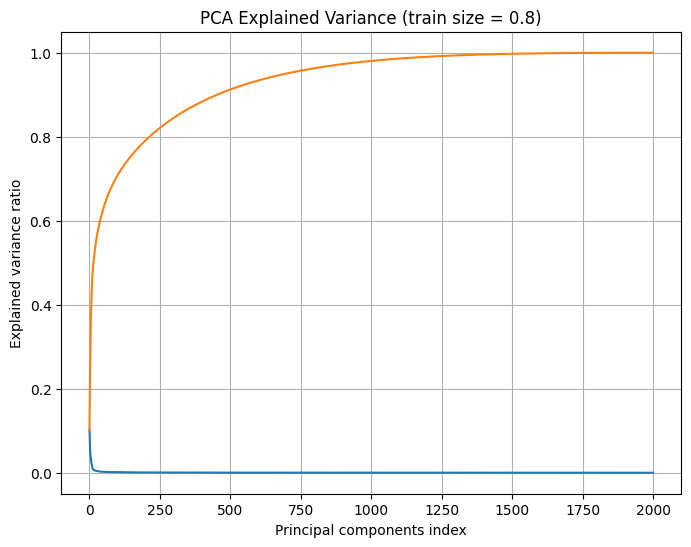



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'pca__n_components': 20}
grid_search.best_score_:  0.9851069645332828


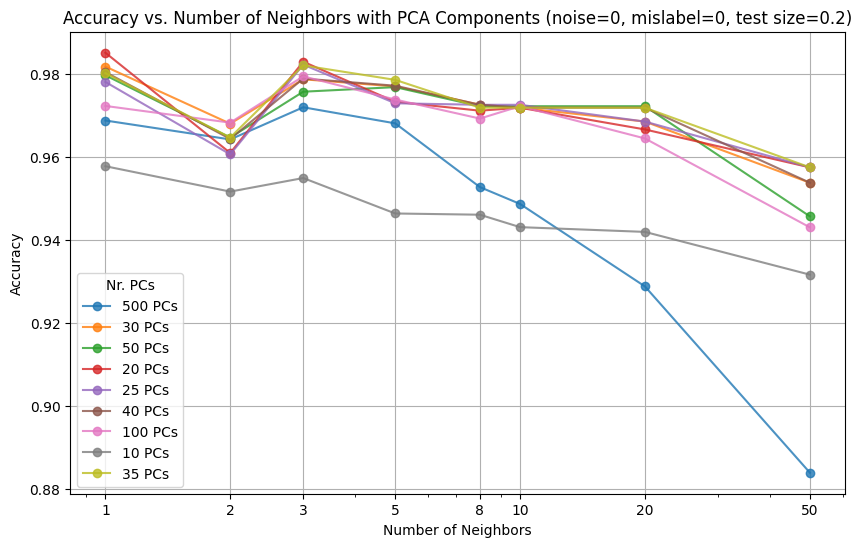

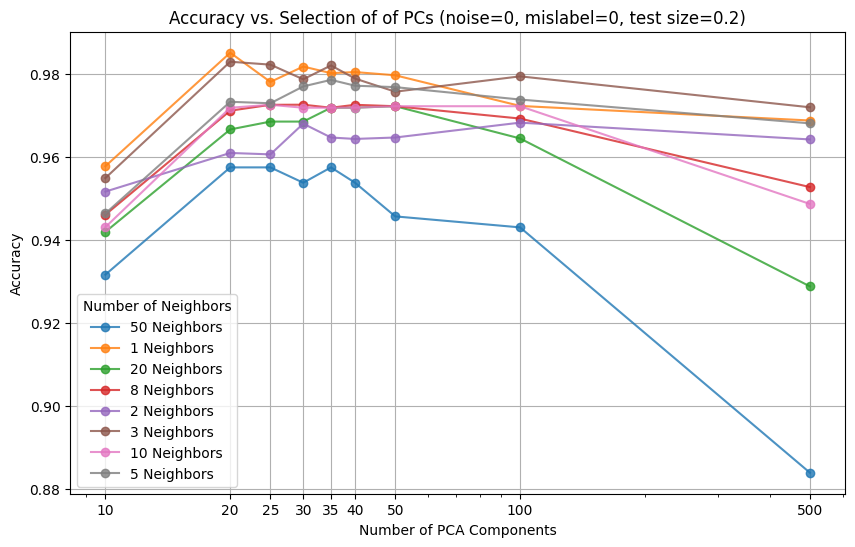

grid_search.best_params_:  {'estimator__n_neighbors': 3, 'kbest__k': 200, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.9912738133558914


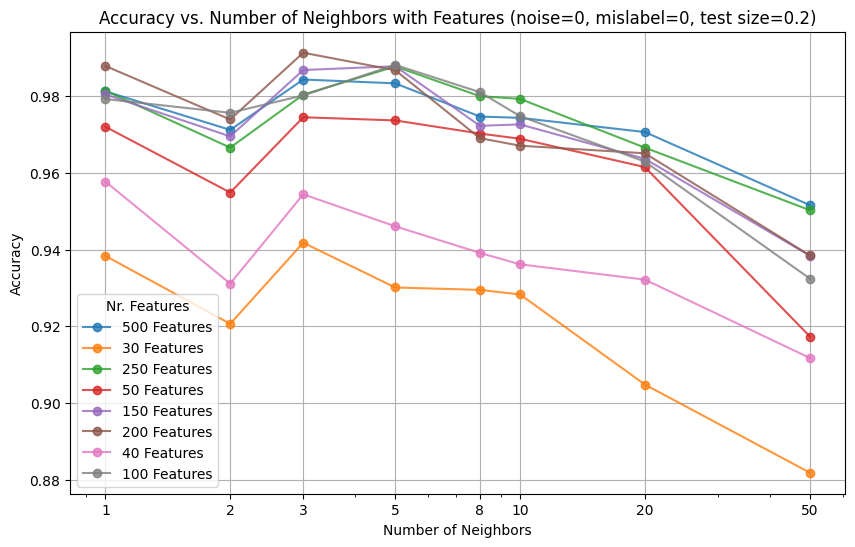

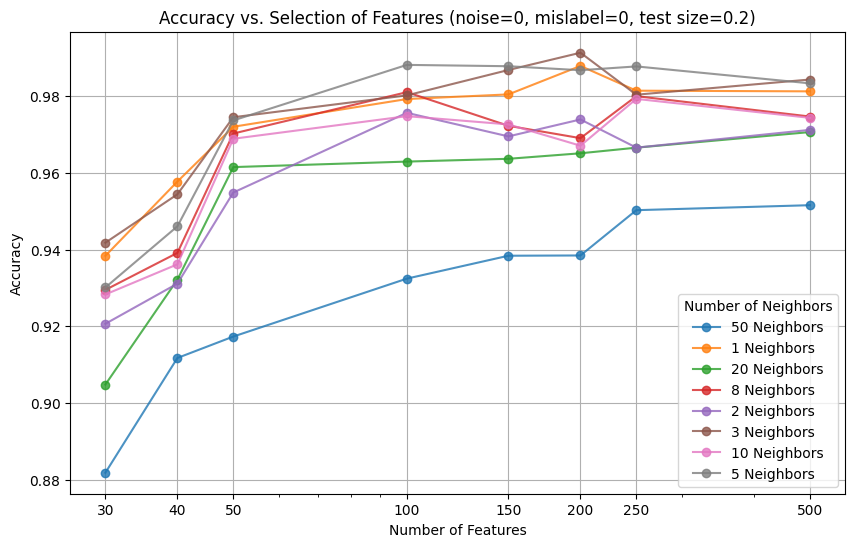

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.95773789 0.98510696 0.97806586 0.98176956 0.98018226 0.98044177
 0.9796668  0.97227434 0.96876113 0.95161504 0.96093382 0.96059416
 0.96799758 0.9646562  0.96431654 0.96466018 0.96824567 0.96419434
 0.95488596 0.98293874 0.98223278 0.97870002 0.9820414  0.97887272
 0.97570626 0.97940996 0.97194937 0.94633949 0.97327723 0.97291491
 0.97698094 0.97855915 0.97715276 0.97680911 0.97381535 0.96807385
 0.94604221 0.97112873 0.97254861 0.97257127 0.97184265 0.97254861
 0.97220497 0.96922989 0.95270223 0.94304446 0.97183867 0.97254861
 0.97184265 0.97186133 0.97186133 0.97220497 0.97220497 0.94863621
 0.9418993  0.96660483 0.96850127 0.96850127 0.97184265 0.97186133
 0.97220895 0.96443524 0.92875539 0.93158184 0.95745519 0.95745519
 0.95375148 0.95745519 0.95375148 0.94563811 0.942988   0.88382181]
For k=1 and PCA components=20, CV Score: 0.9851069645332828, Test Score: 0.9833676268861455, Train Score: 1.0
For k=2 and PCA compon

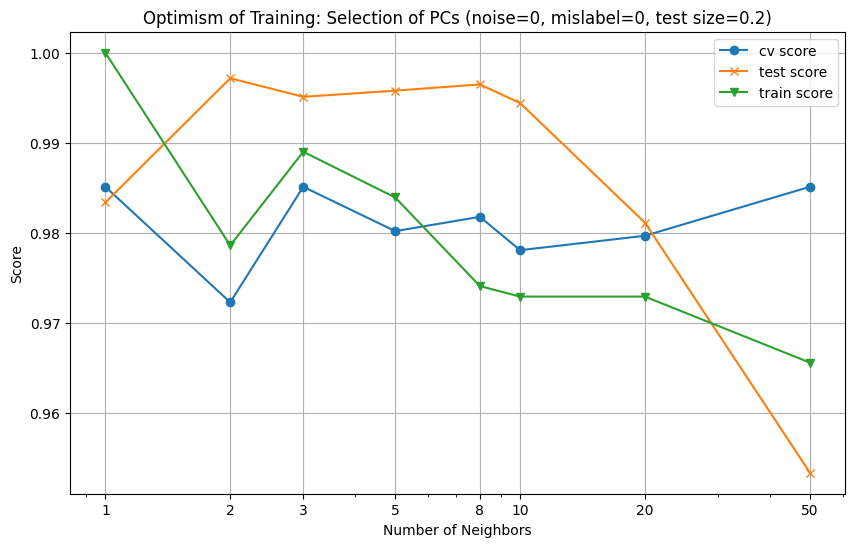

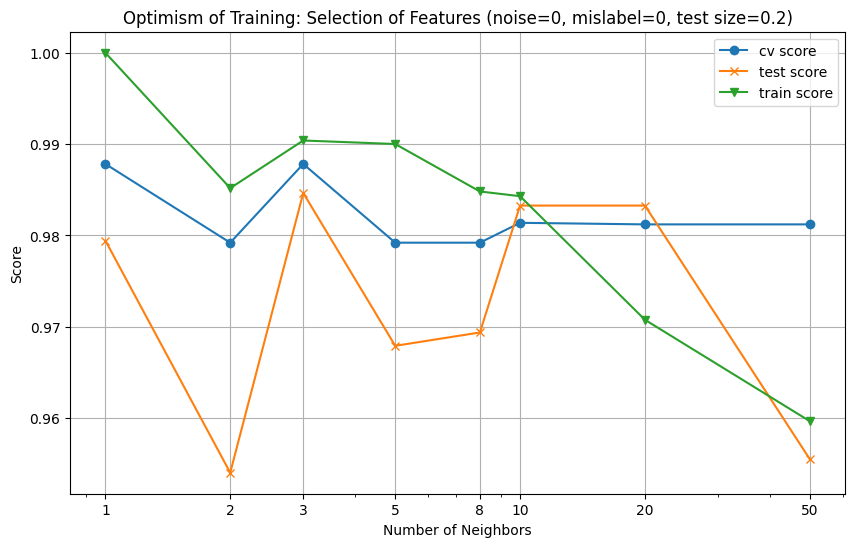



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.2 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'pca__n_components': 100}
grid_search.best_score_:  0.6754932144423008


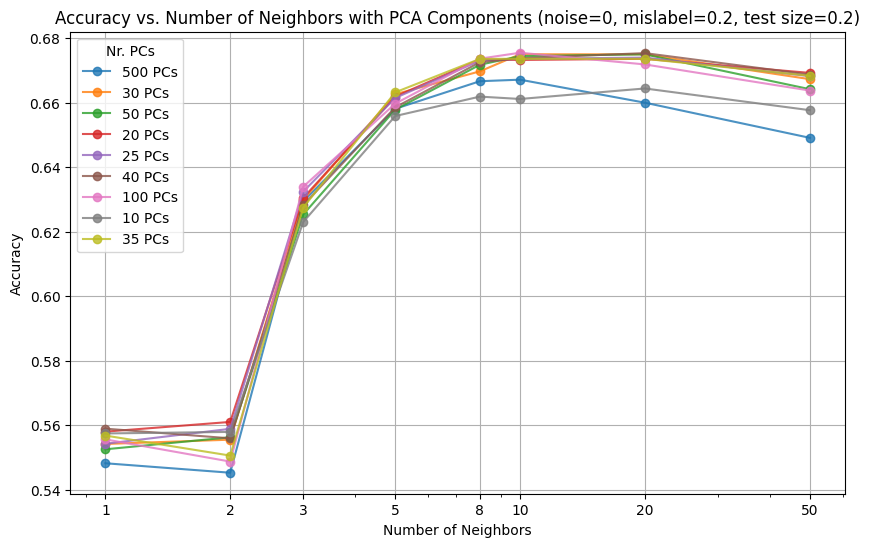

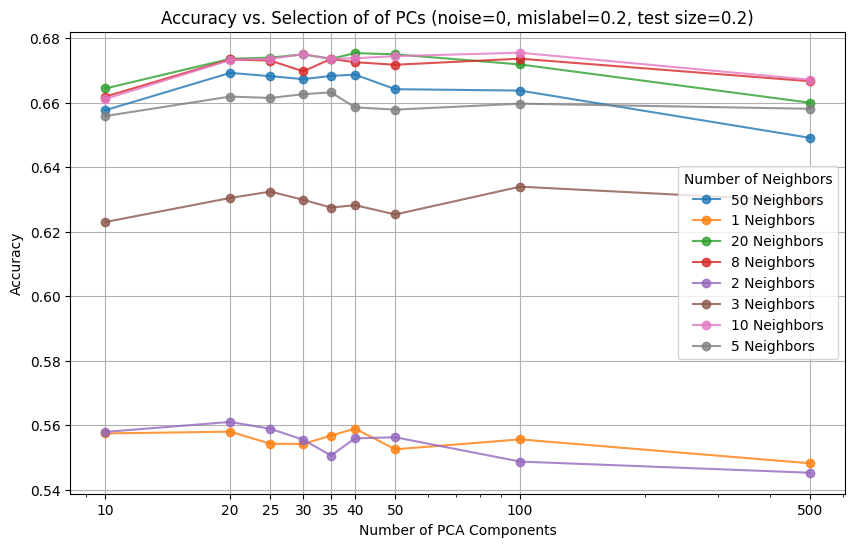

grid_search.best_params_:  {'estimator__n_neighbors': 10, 'kbest__k': 200, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.6800551551188936


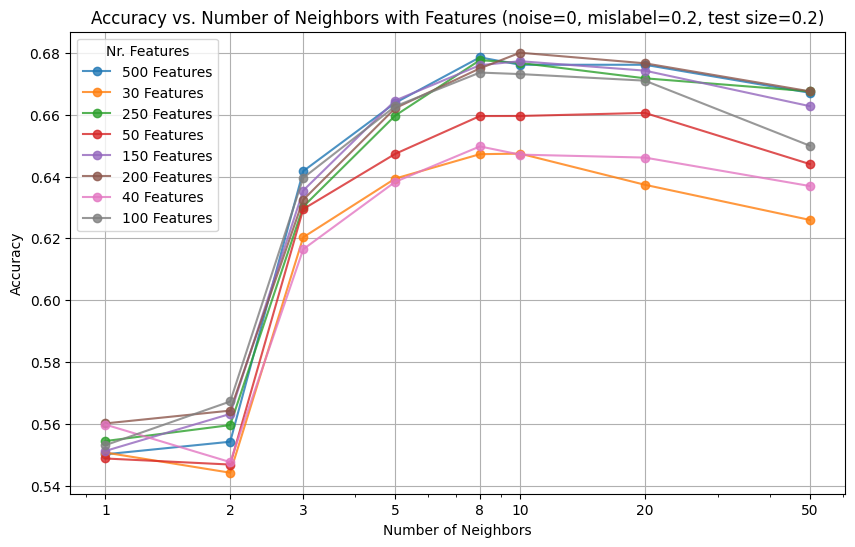

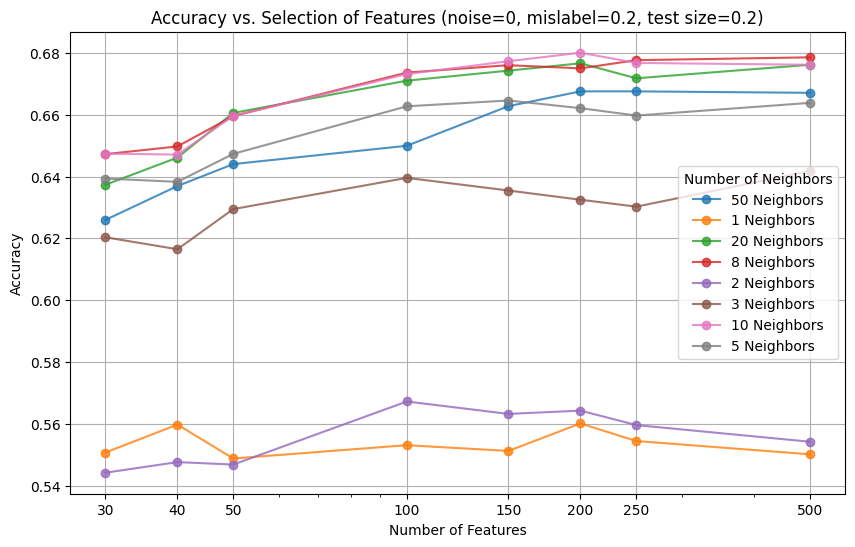

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.55741846 0.55797688 0.55422305 0.55416236 0.55676417 0.55890528
 0.5525016  0.55557463 0.54817272 0.55789408 0.56099095 0.55885145
 0.55548682 0.55055249 0.55590381 0.5562302  0.54869613 0.54523809
 0.62299188 0.63045893 0.63242091 0.62988112 0.62747577 0.62821407
 0.62533217 0.63394888 0.629392   0.65585784 0.66189423 0.6614683
 0.662635   0.66320905 0.65855529 0.65784064 0.65969353 0.65810657
 0.66188368 0.67340098 0.67304637 0.66971478 0.67358056 0.67254628
 0.67176099 0.67365113 0.66665649 0.6611479  0.67324962 0.67360423
 0.6750173  0.67360423 0.67378381 0.67443526 0.67549321 0.66713332
 0.66440663 0.67360423 0.67398302 0.67499312 0.67360423 0.67537191
 0.67499312 0.67186074 0.6599985  0.65766536 0.66923317 0.66822306
 0.66728872 0.668323   0.66870179 0.66418051 0.66375368 0.64909302]
For k=1 and PCA components=40, CV Score: 0.558905275222785, Test Score: 0.7432373354612963, Train Score: 1.0
For k=2 and PCA componen

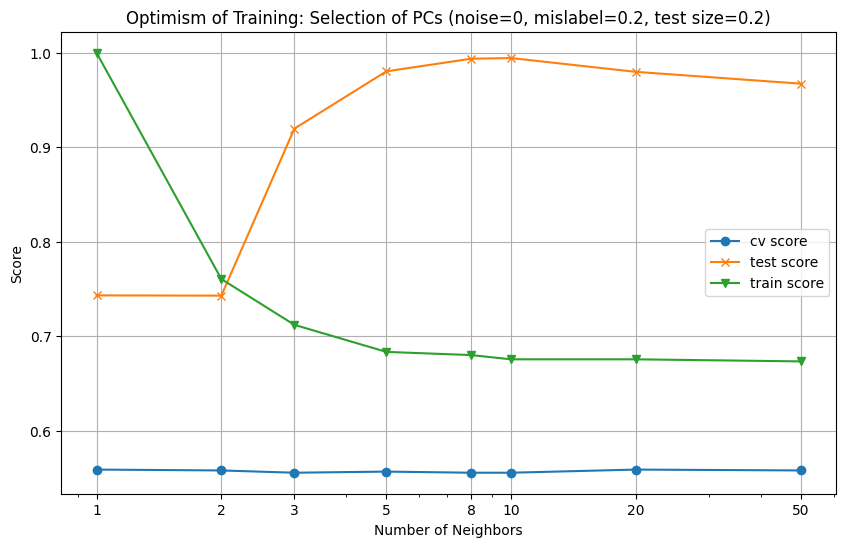

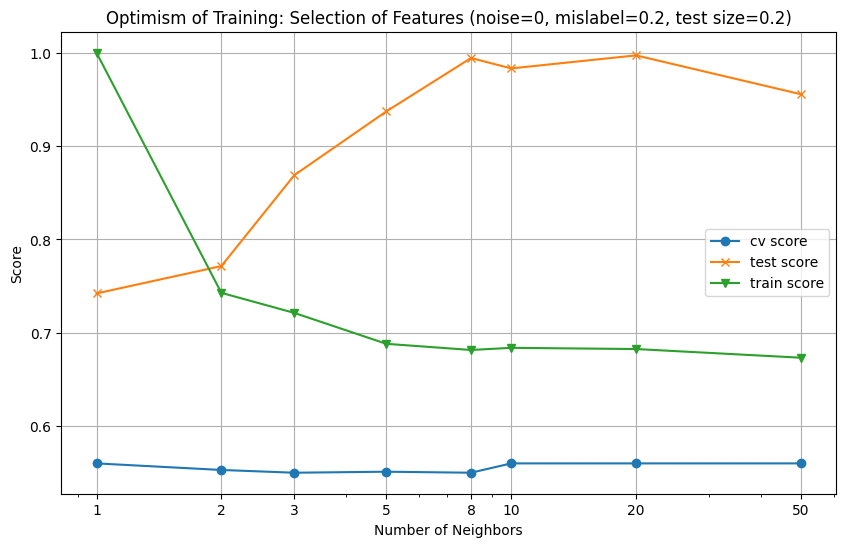



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.4 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 20}
grid_search.best_score_:  0.42748167894988526


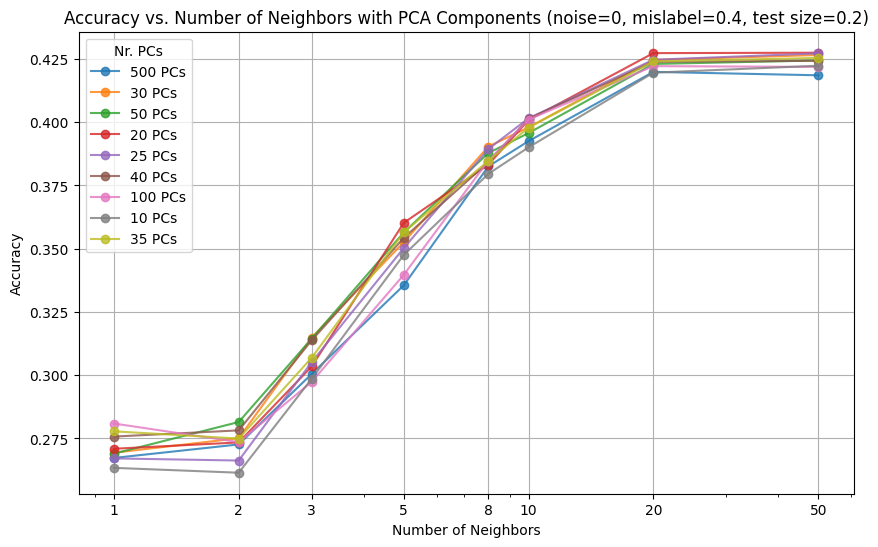

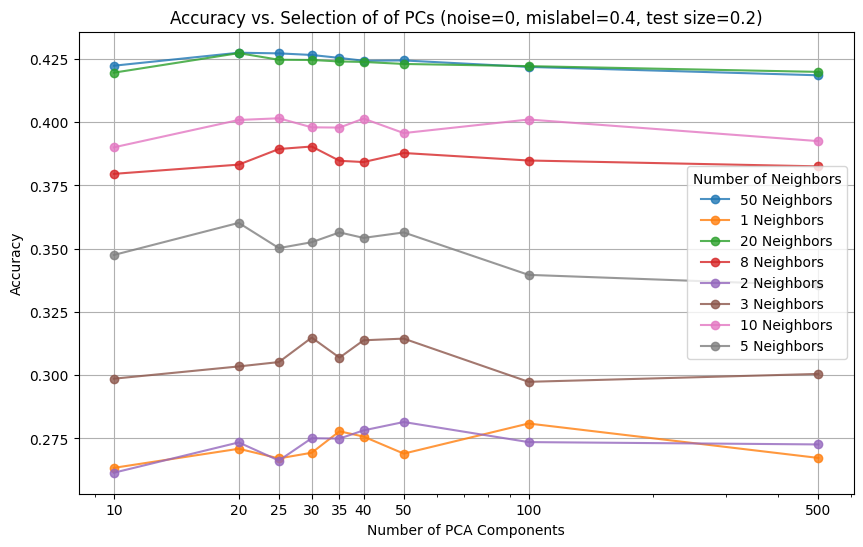

grid_search.best_params_:  {'estimator__n_neighbors': 20, 'kbest__k': 500, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.42488773035731614


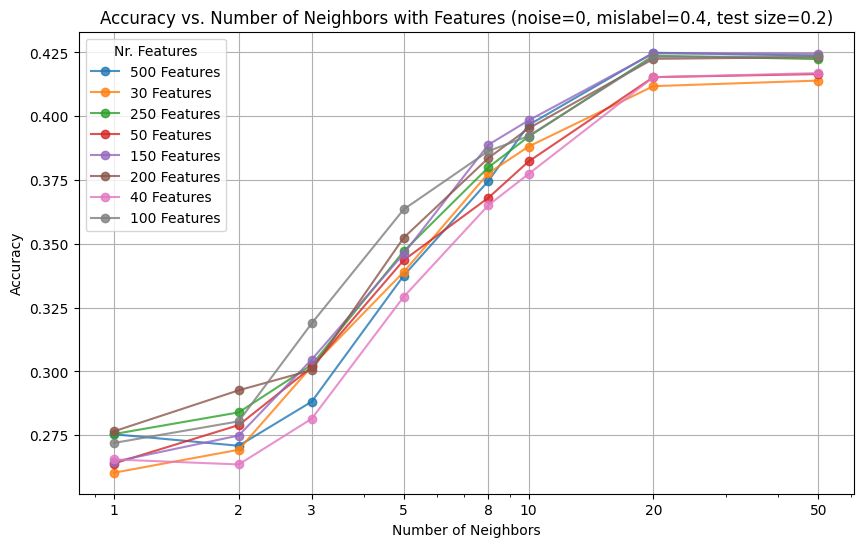

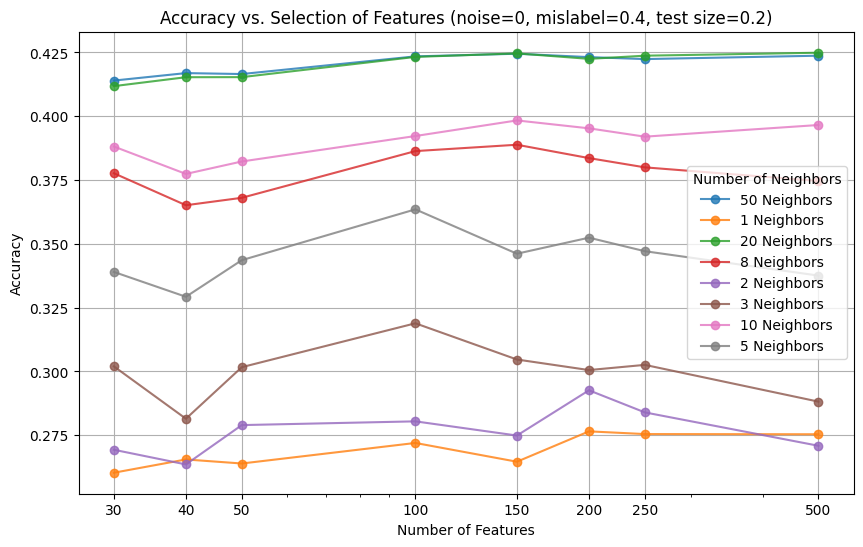

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.26339022 0.27093438 0.26712426 0.26936849 0.27783535 0.27575649
 0.26901651 0.28092254 0.26730777 0.26146681 0.27344493 0.2662851
 0.27510615 0.27495987 0.27820688 0.28150865 0.27357394 0.27265042
 0.29863245 0.30348316 0.30520312 0.31487862 0.30694927 0.31381376
 0.31448014 0.29739698 0.30052238 0.34753909 0.36022428 0.3502542
 0.35257602 0.35645868 0.35428482 0.35644727 0.33967657 0.33552255
 0.37960071 0.38324899 0.38942373 0.39041039 0.38476959 0.38426523
 0.38784272 0.38487885 0.38256617 0.39008896 0.4008964  0.40156598
 0.39799213 0.39789358 0.40144504 0.39571734 0.4010845  0.39253804
 0.41959903 0.427325   0.42469908 0.42461199 0.42402878 0.42384137
 0.42304332 0.42217814 0.41990505 0.42234919 0.42748168 0.42722485
 0.42659466 0.42542669 0.4243078  0.42443213 0.42187244 0.4185614 ]
For k=1 and PCA components=100, CV Score: 0.2809225381130432, Test Score: 0.5059435865171975, Train Score: 1.0
For k=2 and PCA compone

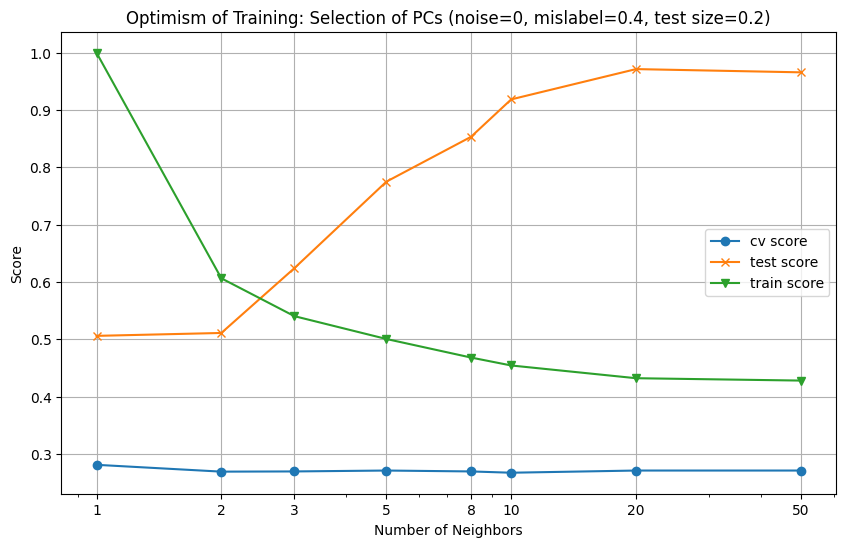

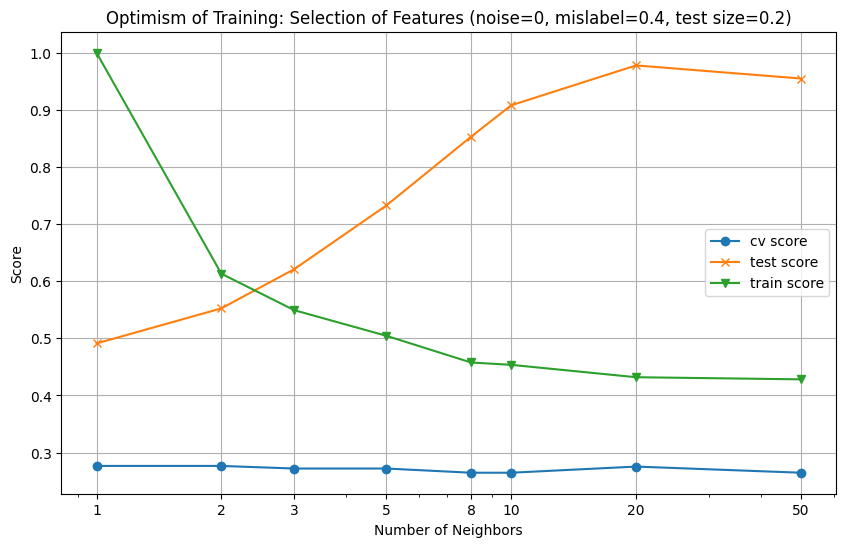



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.6 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 20}
grid_search.best_score_:  0.22809736659437901


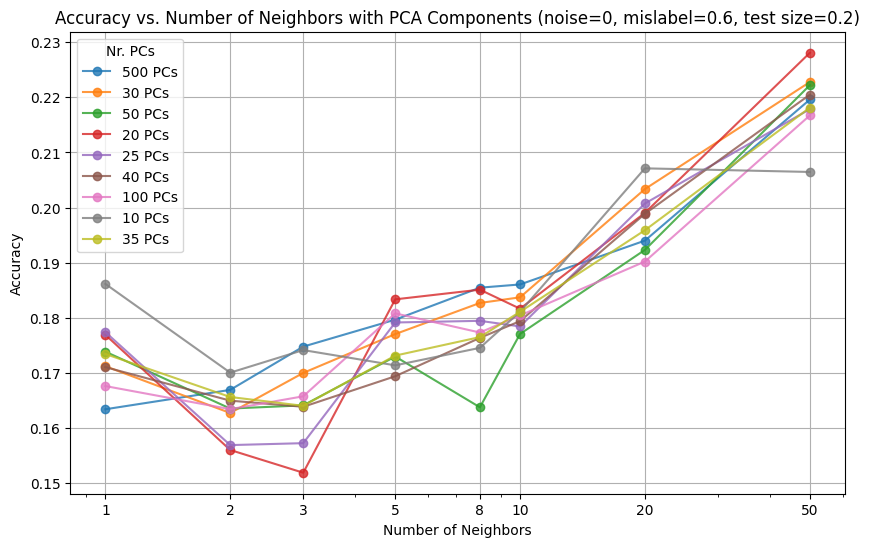

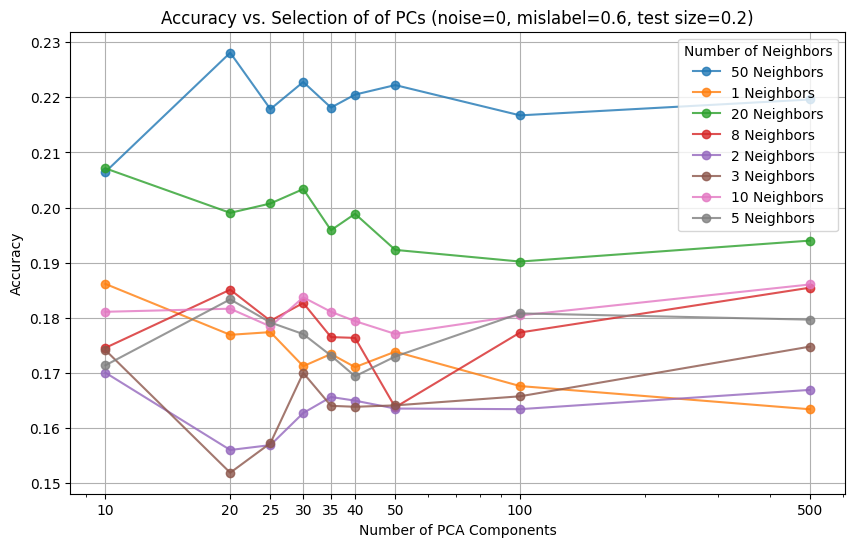

grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 500, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.21535898902682754


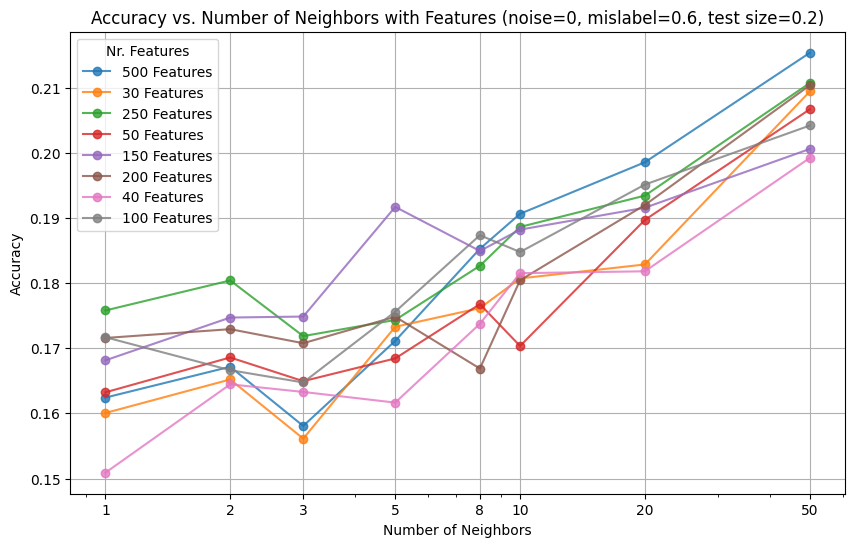

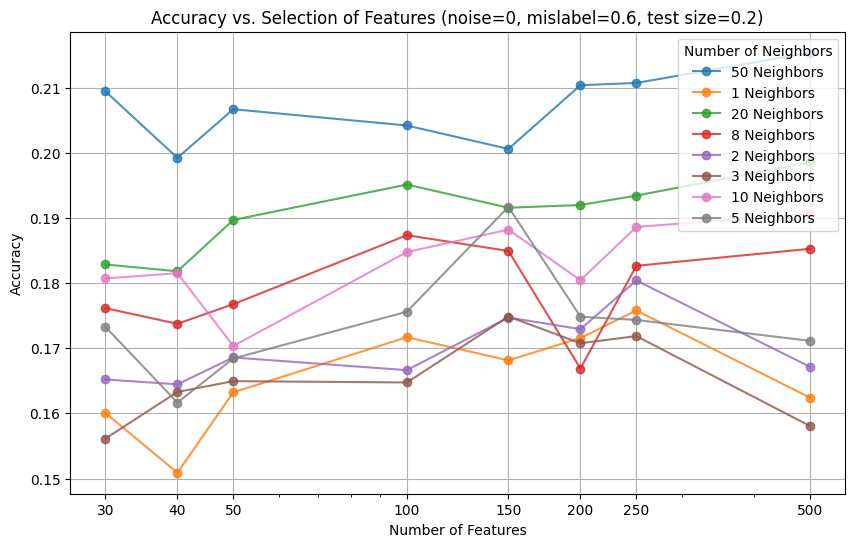

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.18614327 0.17690444 0.17739435 0.17120905 0.17342443 0.17104001
 0.173848   0.16760482 0.16339658 0.17003839 0.15600532 0.15689266
 0.16271512 0.16562234 0.16495853 0.16352371 0.16341468 0.16691128
 0.1741363  0.1518795  0.1572428  0.16999219 0.16402138 0.16384341
 0.16410165 0.16574733 0.17476415 0.17136594 0.18334366 0.17914342
 0.17703718 0.17313274 0.16938597 0.17296576 0.18079556 0.17965859
 0.17453907 0.18509974 0.17944146 0.18268479 0.1764903  0.17634862
 0.16375379 0.17732471 0.18545925 0.18108455 0.18164362 0.17842654
 0.18371033 0.18108495 0.17939081 0.17706612 0.18041705 0.18604274
 0.20711552 0.19903674 0.20073569 0.20335375 0.19588467 0.19886379
 0.1923165  0.19020065 0.19400062 0.20645945 0.22809737 0.21786354
 0.22278775 0.21814212 0.22049786 0.22222508 0.2167299  0.21960904]
For k=1 and PCA components=10, CV Score: 0.18614327410033163, Test Score: 0.24803838939142656, Train Score: 1.0
For k=2 and PCA comp

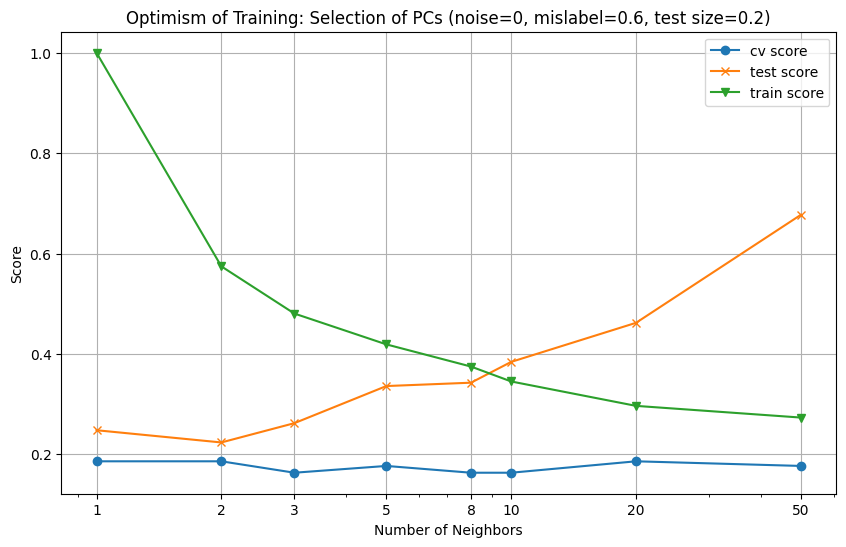

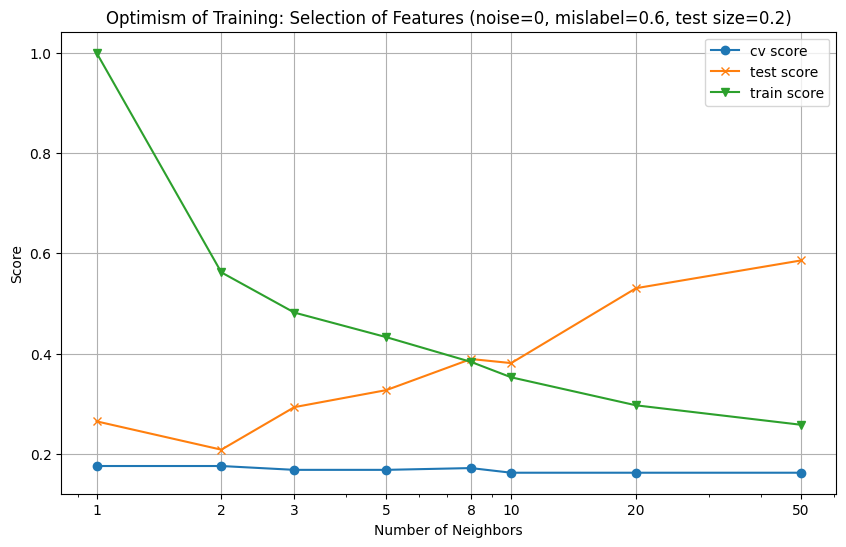

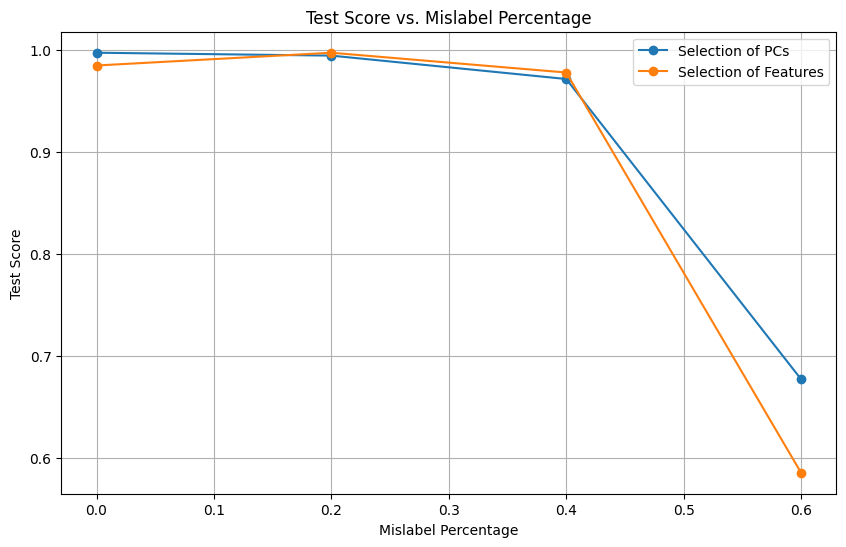



 X_train shape = (1732, 2000), Y_train shape = (1732, 1)
Number of components needed to explain 80% variance: 194
Number of components needed to explain 50% variance: 15


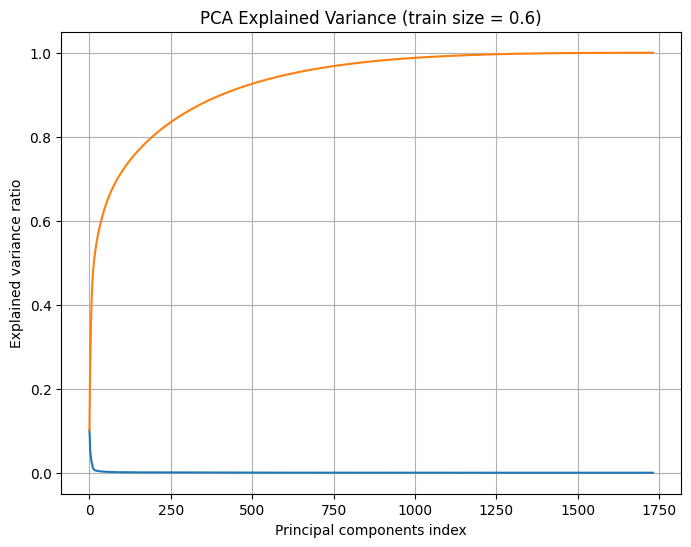



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'pca__n_components': 25}
grid_search.best_score_:  0.9752244125265751


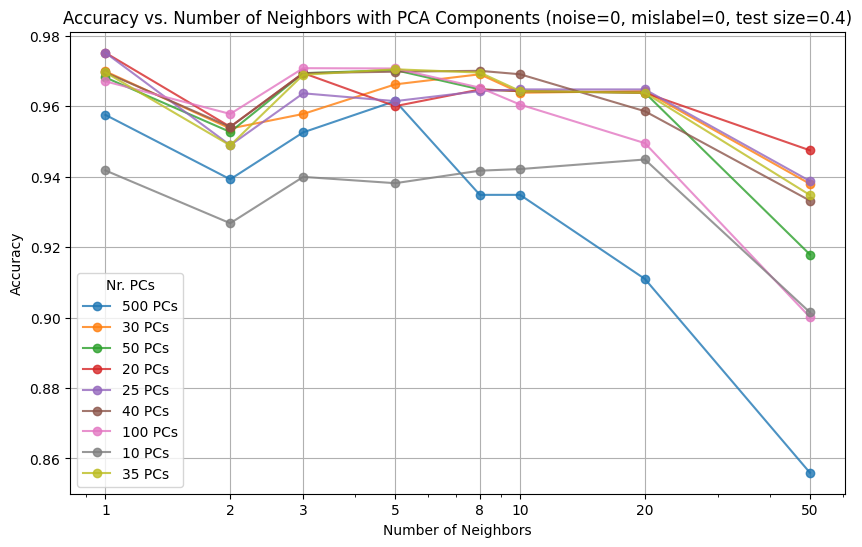

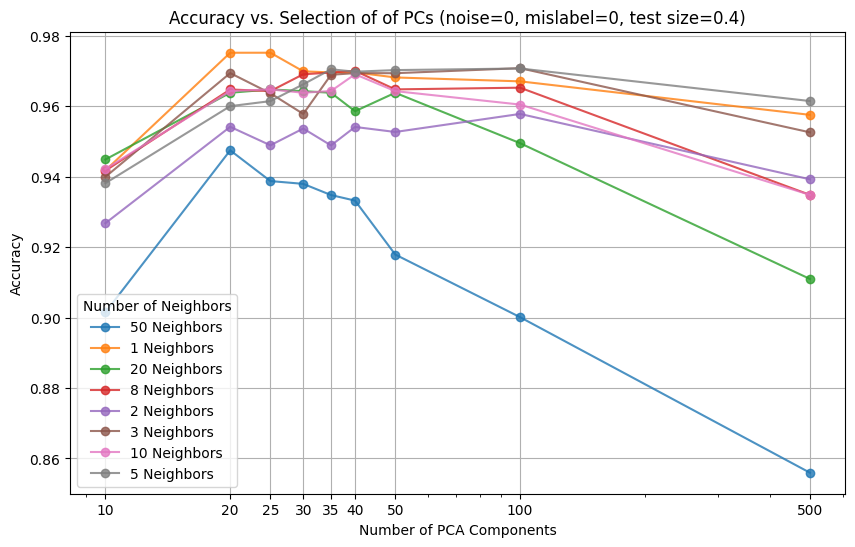

grid_search.best_params_:  {'estimator__n_neighbors': 1, 'kbest__k': 200, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.985661464059517


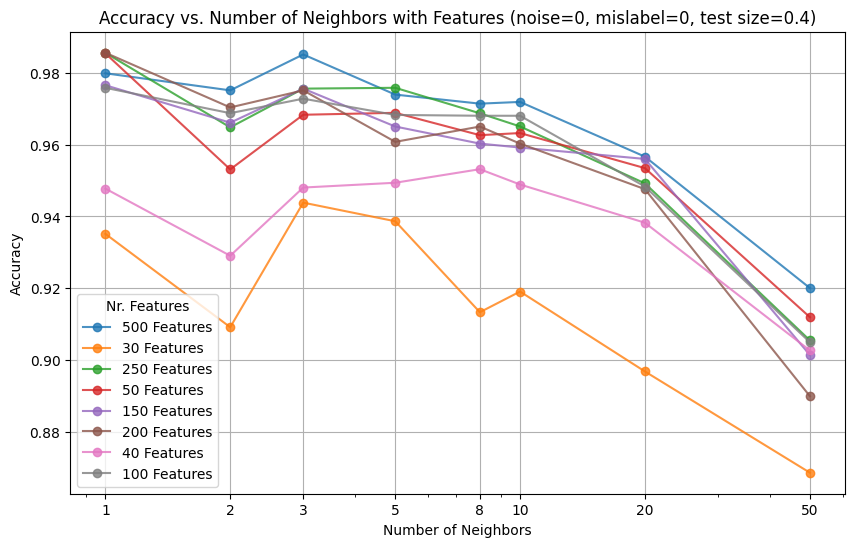

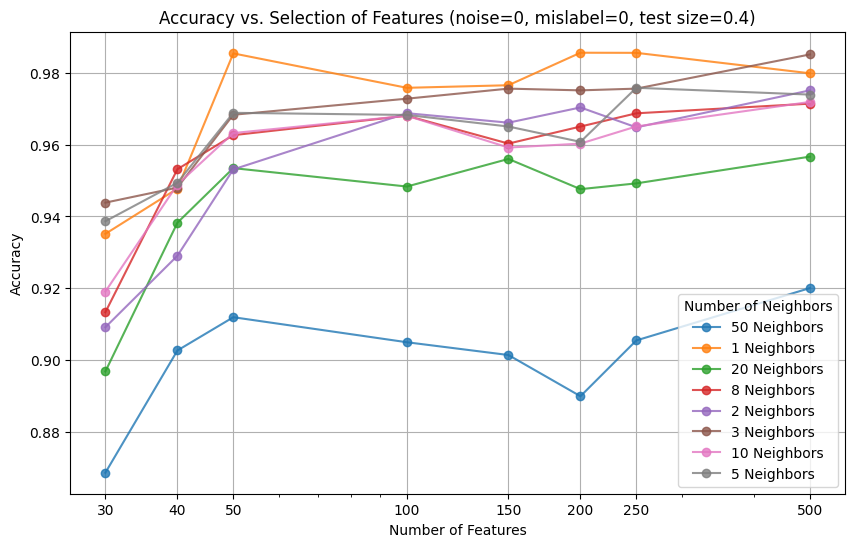

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.94179242 0.97521731 0.97522441 0.96993874 0.96963528 0.96964239
 0.96819903 0.96709482 0.95757812 0.92679446 0.95418154 0.94892944
 0.95369135 0.94889587 0.95414086 0.95271172 0.95784    0.93926994
 0.93995583 0.96944055 0.96369825 0.95783924 0.96895035 0.96944055
 0.96940697 0.97083688 0.95261188 0.93816746 0.96004766 0.96147757
 0.96623947 0.97051829 0.96983335 0.97028997 0.9707466  0.96150019
 0.94172142 0.96478309 0.96432647 0.9691014  0.9695916  0.97008179
 0.96481033 0.96529342 0.9348531  0.94217804 0.9643466  0.96480322
 0.9638564  0.9643466  0.96910851 0.96432013 0.96049794 0.9348531
 0.94489602 0.96385006 0.96479612 0.96431303 0.96385006 0.95860507
 0.96385006 0.94953788 0.91096631 0.90147988 0.9475003  0.93877014
 0.93797649 0.93480188 0.93321458 0.91790691 0.90010956 0.85592916]
For k=1 and PCA components=25, CV Score: 0.9752244125265751, Test Score: 0.9790435757474857, Train Score: 1.0
For k=2 and PCA compone

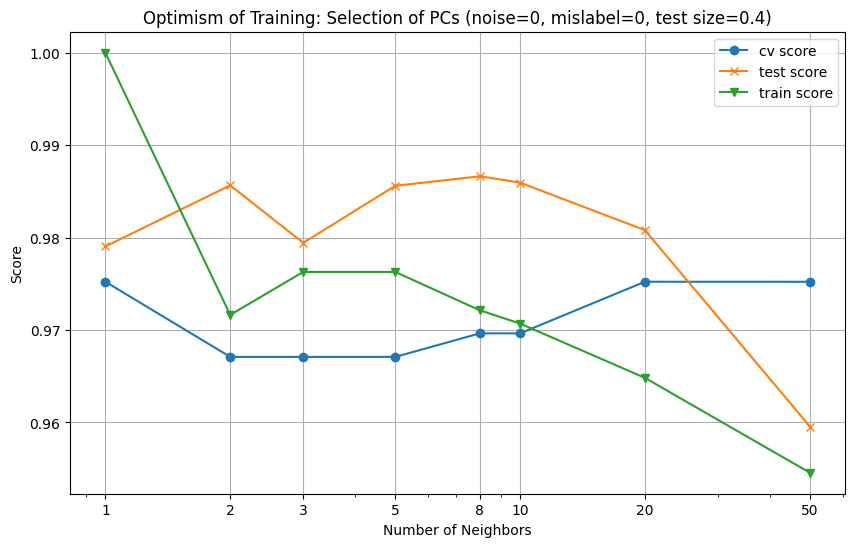

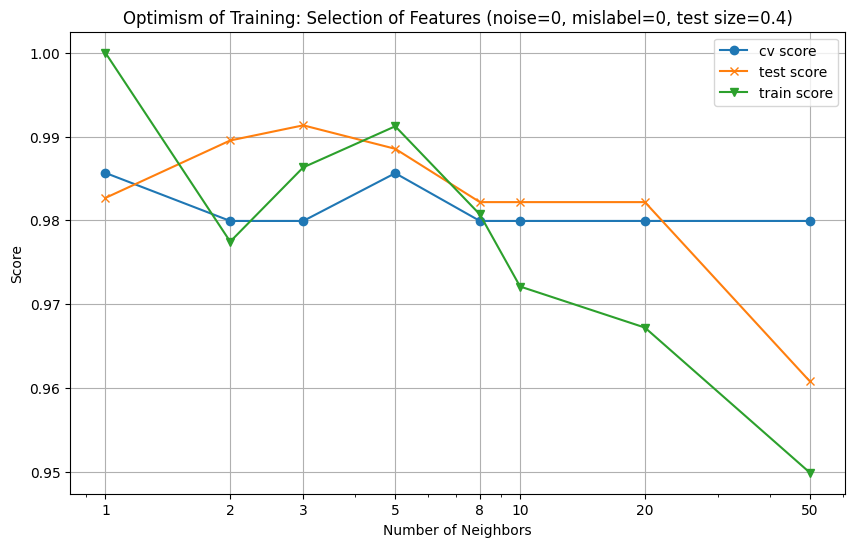



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.2 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'pca__n_components': 50}
grid_search.best_score_:  0.6714951366498452


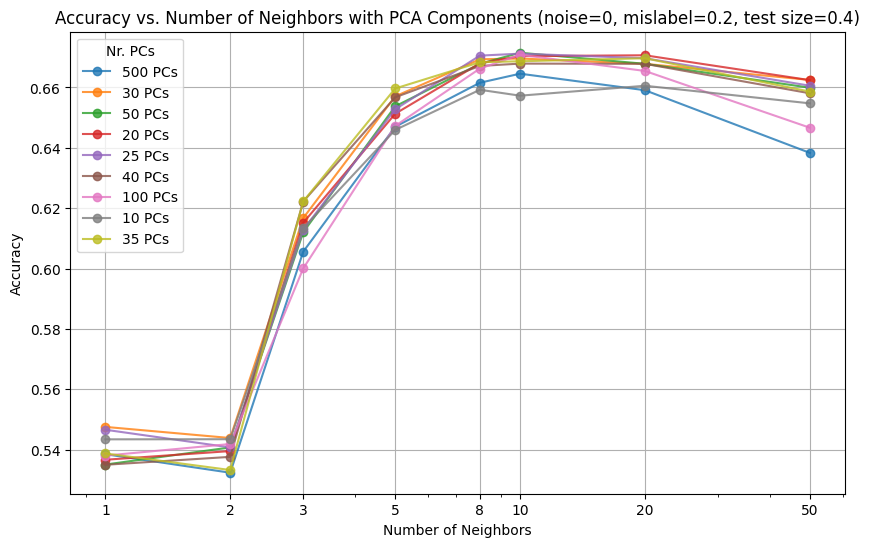

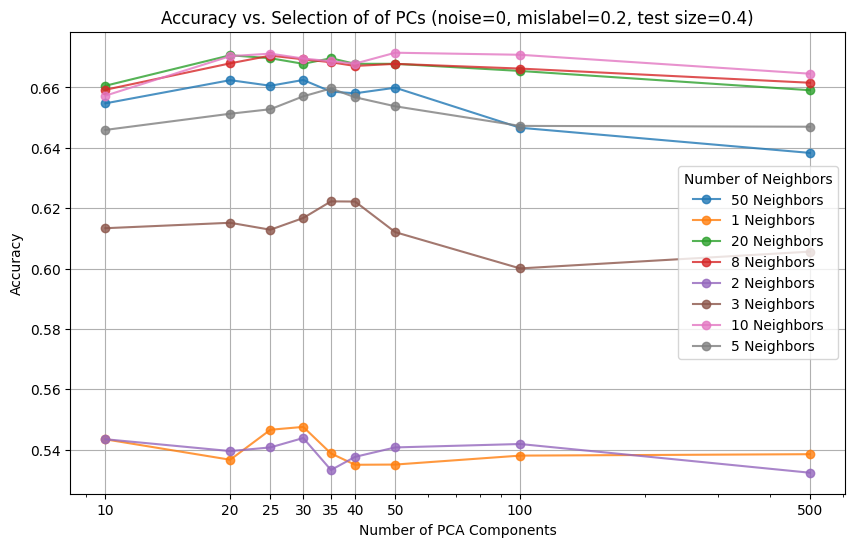

grid_search.best_params_:  {'estimator__n_neighbors': 8, 'kbest__k': 100, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.6735100142002064


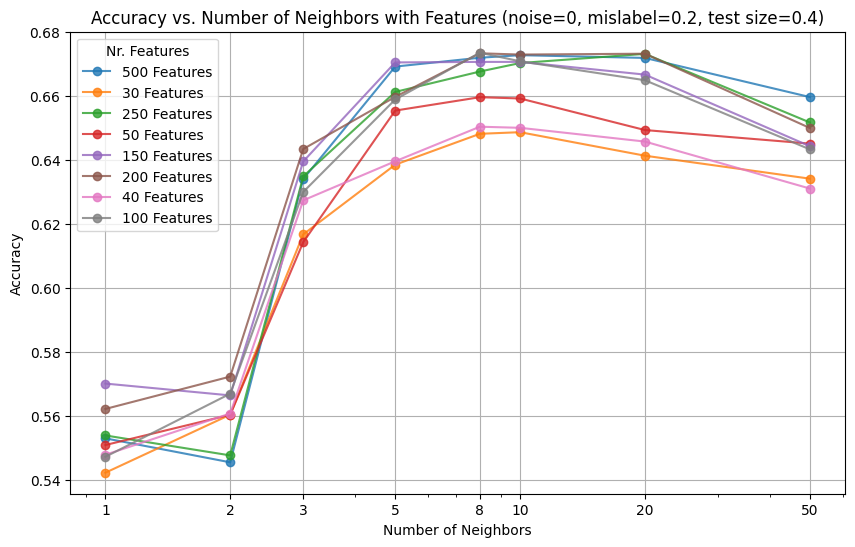

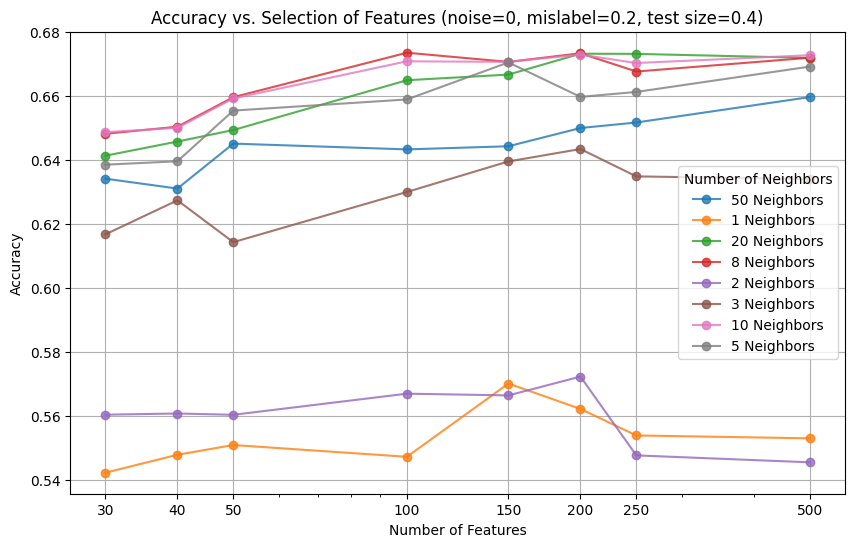

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.54342208 0.53665986 0.54659946 0.54754135 0.53874365 0.53499451
 0.53506638 0.53802918 0.53850003 0.54345869 0.53953393 0.54074941
 0.54385642 0.53325734 0.53761484 0.54074288 0.54187422 0.53236209
 0.61336228 0.61516209 0.61285656 0.61673707 0.62225299 0.62219324
 0.61205387 0.60004225 0.60560101 0.64592    0.65128608 0.65277882
 0.6570516  0.65965259 0.65673615 0.6537497  0.64725462 0.64697972
 0.65922086 0.66797945 0.67053477 0.66931715 0.6683376  0.66711232
 0.6678085  0.66624411 0.66154909 0.65726388 0.6703604  0.67118833
 0.66957542 0.66866548 0.6678889  0.67149514 0.67081602 0.66454758
 0.66054781 0.67065069 0.66967114 0.66781929 0.66967114 0.66781929
 0.66781929 0.66545752 0.65907491 0.65472559 0.66240608 0.66055423
 0.66246824 0.65861519 0.6580534  0.65990525 0.64664329 0.63830996]
For k=1 and PCA components=30, CV Score: 0.5475413476710358, Test Score: 0.7684770822646674, Train Score: 1.0
For k=2 and PCA compon

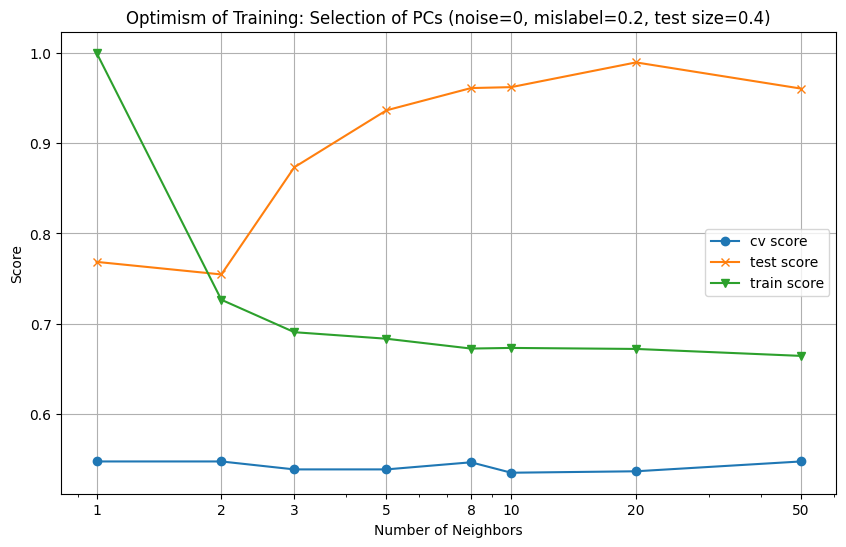

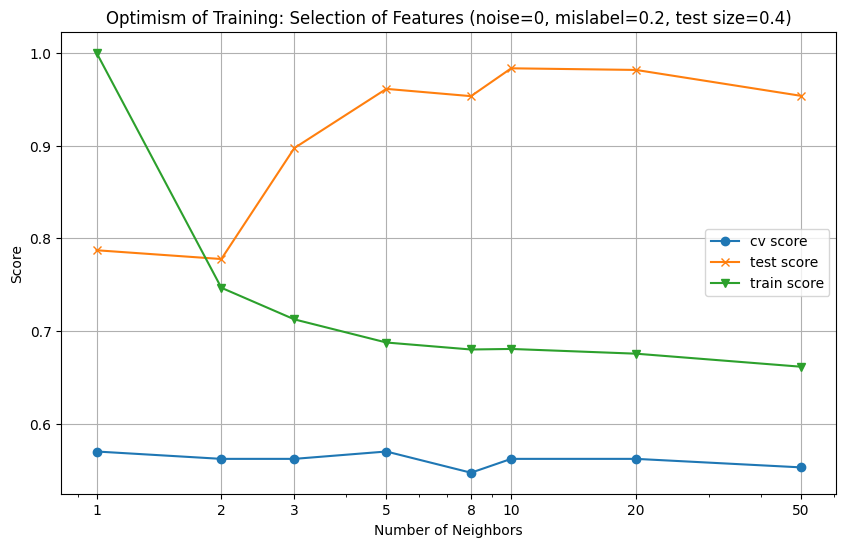



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.4 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 30}
grid_search.best_score_:  0.4142745248651606


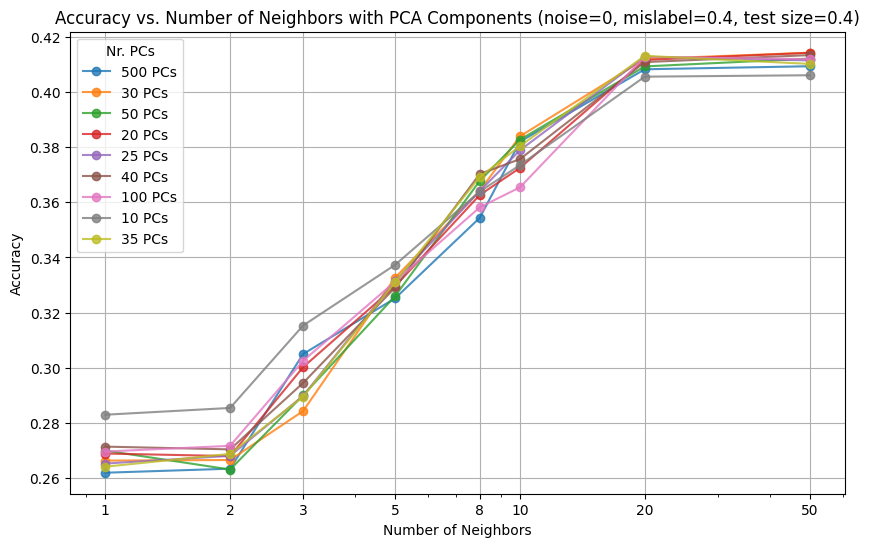

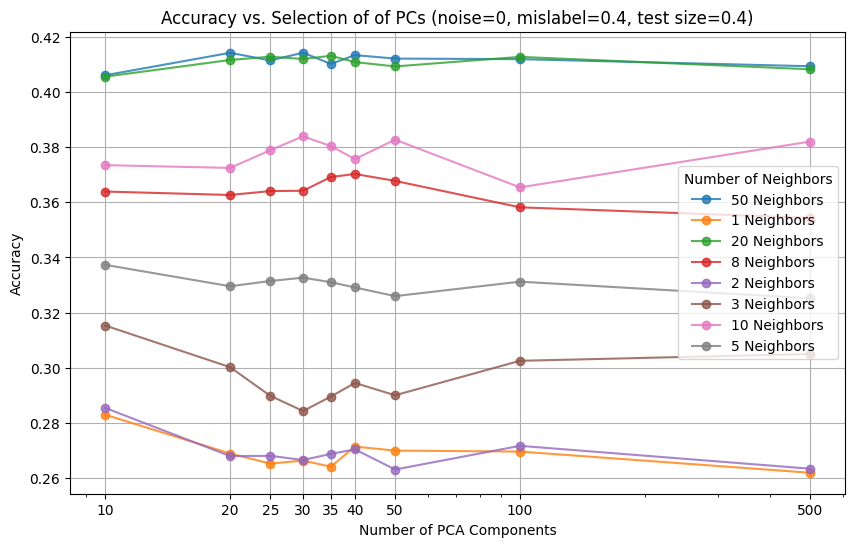

grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 500, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.41334996845748967


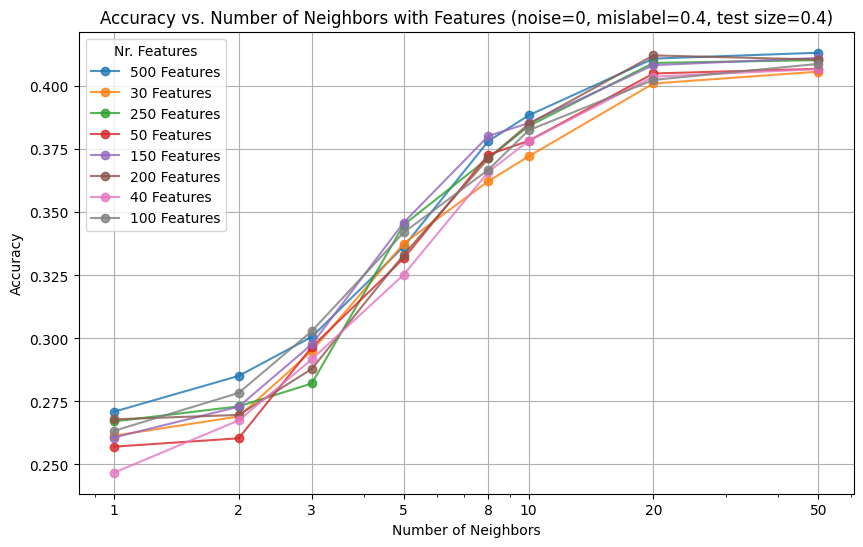

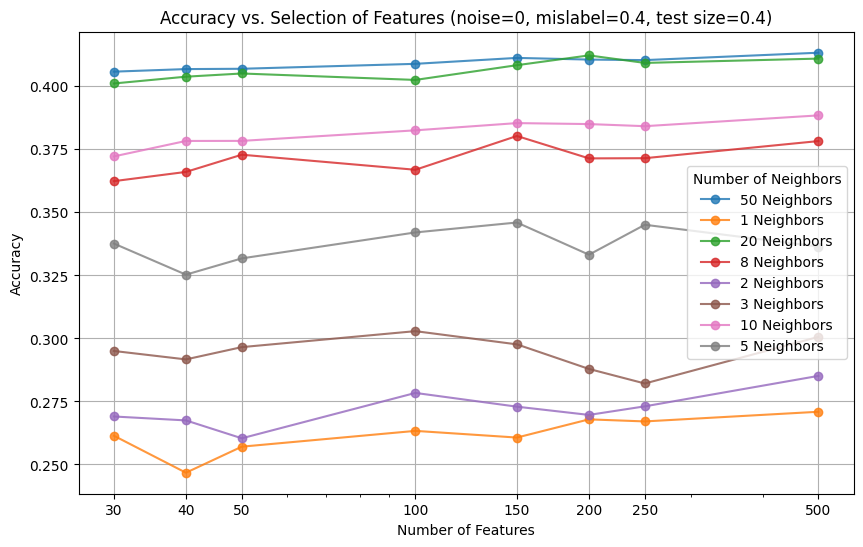

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.28292684 0.26884933 0.26521037 0.26627827 0.26405645 0.27135204
 0.26991358 0.26956072 0.26188274 0.28538405 0.26791892 0.26800611
 0.266499   0.26872468 0.27035353 0.26304336 0.27164271 0.26334671
 0.31528501 0.30018164 0.28978205 0.28426834 0.28952915 0.29445509
 0.28999016 0.30248657 0.30495318 0.3373057  0.3295431  0.3314466
 0.33265133 0.33101309 0.32909488 0.32595591 0.33120775 0.32516825
 0.36390593 0.36265589 0.36407785 0.36419462 0.36917059 0.3702815
 0.36777218 0.35818301 0.35436682 0.37348435 0.37247468 0.37888666
 0.38393359 0.38040018 0.37566696 0.38272384 0.36542519 0.38200686
 0.40558852 0.41165157 0.41283023 0.41200295 0.41314163 0.41087642
 0.40930262 0.41276989 0.40826795 0.40610188 0.41424651 0.41148024
 0.41427452 0.41021578 0.41340623 0.41214629 0.41193933 0.40937331]
For k=1 and PCA components=10, CV Score: 0.2829268433906197, Test Score: 0.5266475238132974, Train Score: 1.0
For k=2 and PCA componen

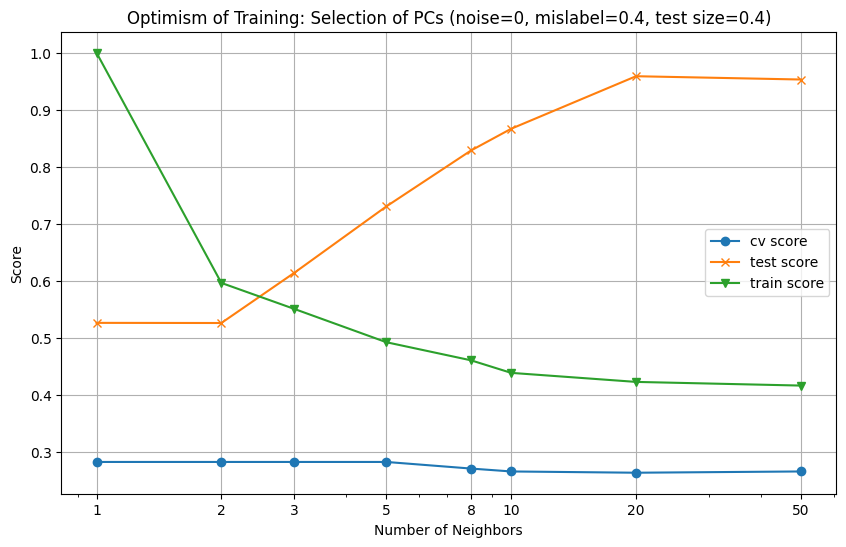

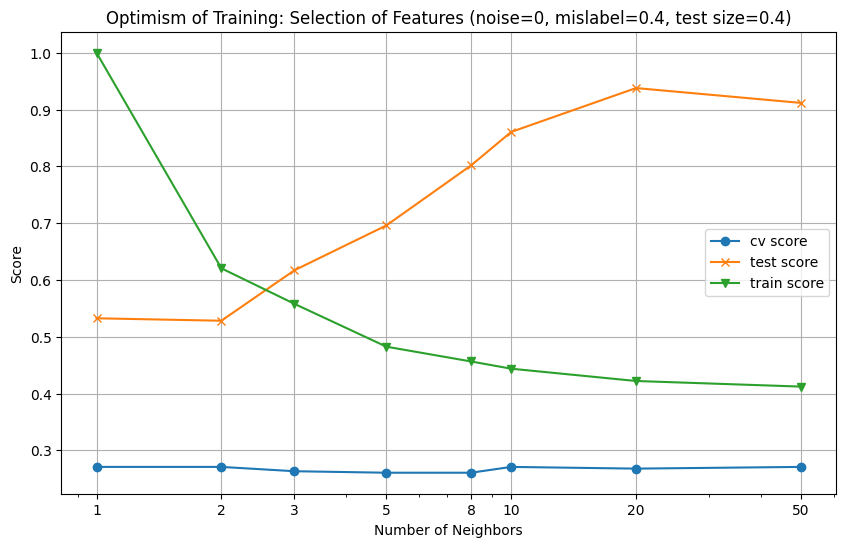



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.6 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 20, 'pca__n_components': 10}
grid_search.best_score_:  0.2171362691727119


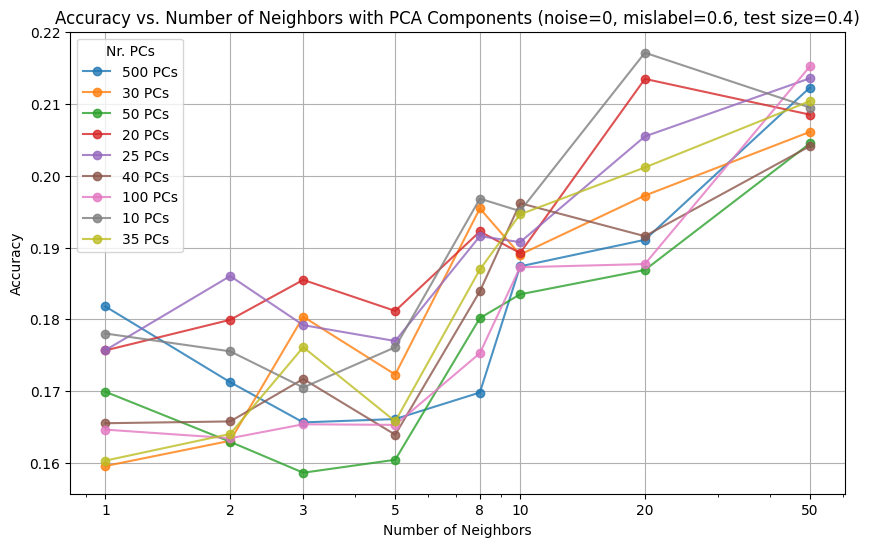

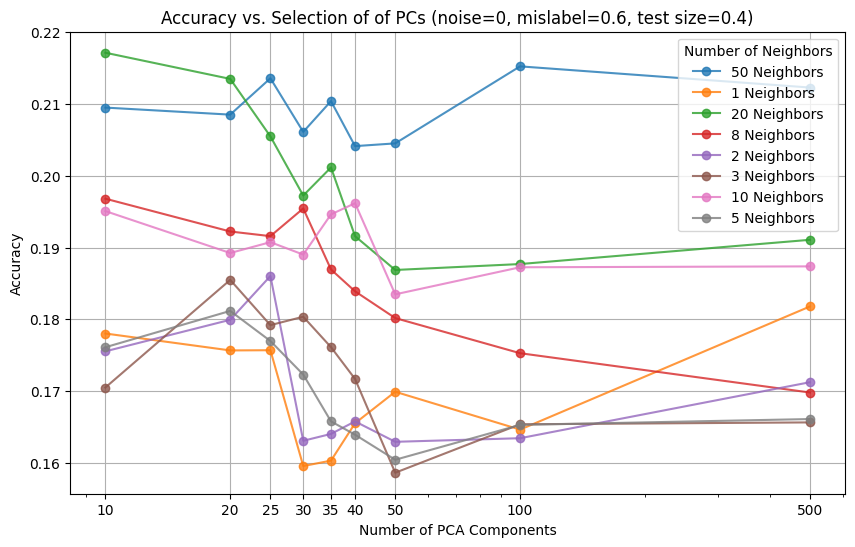

grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 250, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.21049387292546515


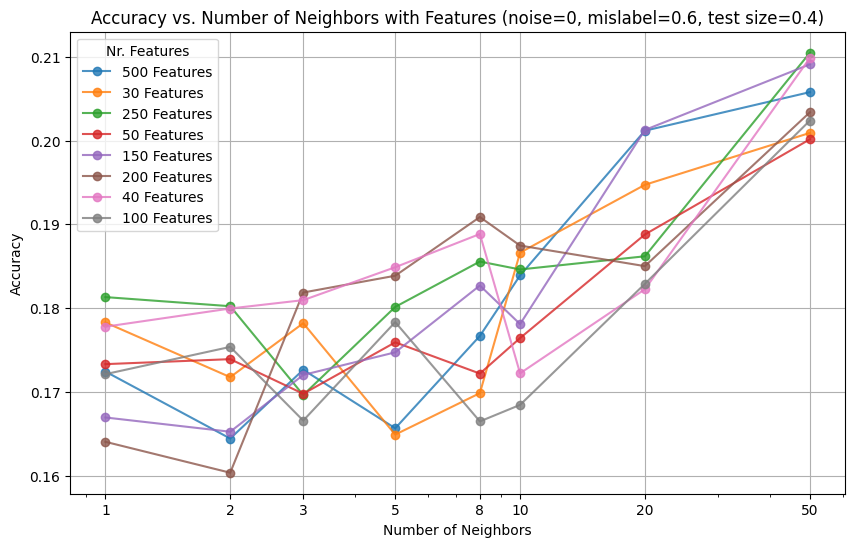

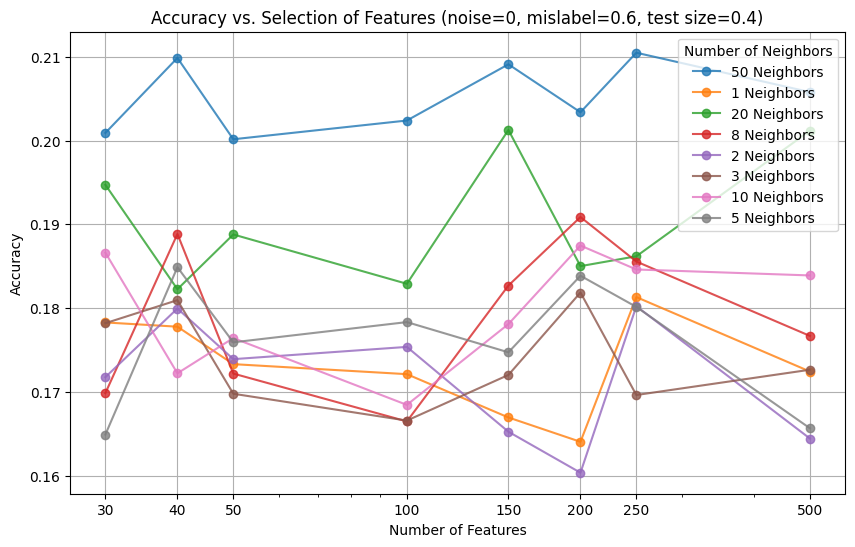

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.17803052 0.17567436 0.17570313 0.15957335 0.1603261  0.165535
 0.16991656 0.16464515 0.18179559 0.17554741 0.179939   0.18603587
 0.16309129 0.16404496 0.16578632 0.1629472  0.1634481  0.17124641
 0.17050992 0.18549808 0.17919669 0.18036637 0.17612738 0.17169943
 0.15864193 0.16538909 0.16565044 0.17611687 0.18117658 0.17698671
 0.17231522 0.1657932  0.16393727 0.16044534 0.16530379 0.16611714
 0.19680819 0.19223753 0.19159007 0.19544579 0.18694662 0.18390743
 0.18018017 0.17528808 0.16981307 0.1950794  0.1892416  0.19075321
 0.18902086 0.19462337 0.19617863 0.18348624 0.18725571 0.18737968
 0.21713627 0.21349088 0.20548104 0.19724241 0.20115962 0.19158645
 0.18687881 0.18770465 0.19108097 0.20949544 0.20851374 0.2135767
 0.20611371 0.21039709 0.20412777 0.20450974 0.21523657 0.21228722]
For k=1 and PCA components=500, CV Score: 0.1817955939571154, Test Score: 0.20316043495614197, Train Score: 1.0
For k=2 and PCA compone

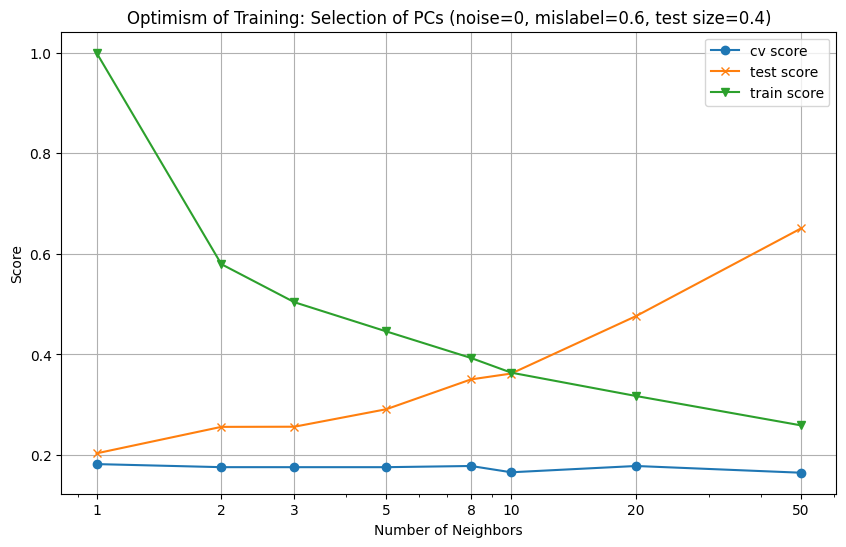

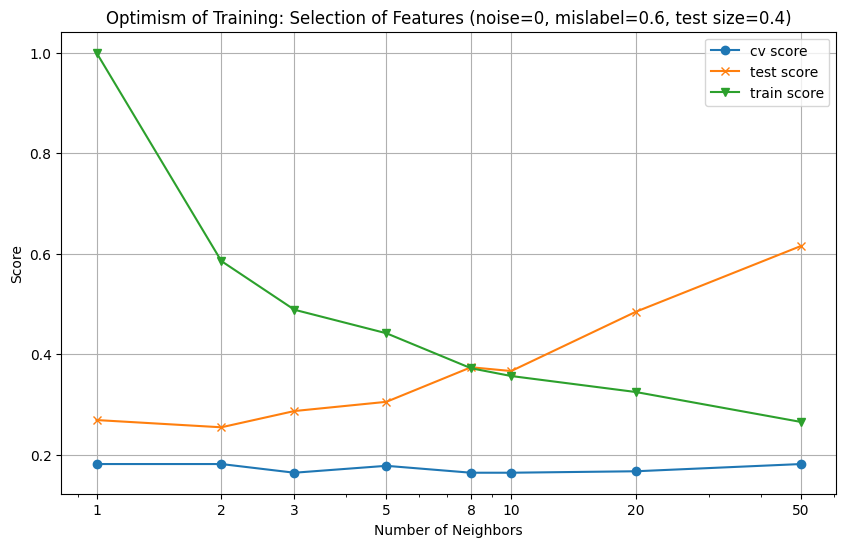

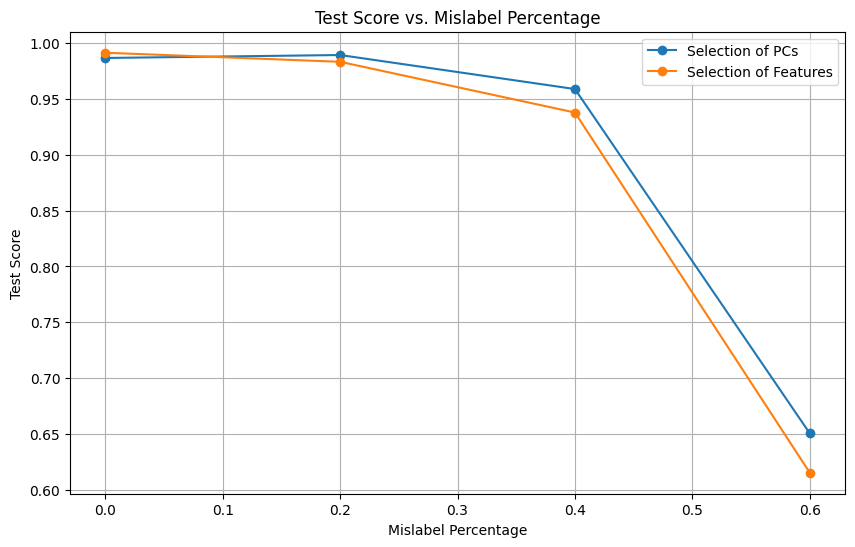



 X_train shape = (866, 2000), Y_train shape = (866, 1)
Number of components needed to explain 80% variance: 149
Number of components needed to explain 50% variance: 14


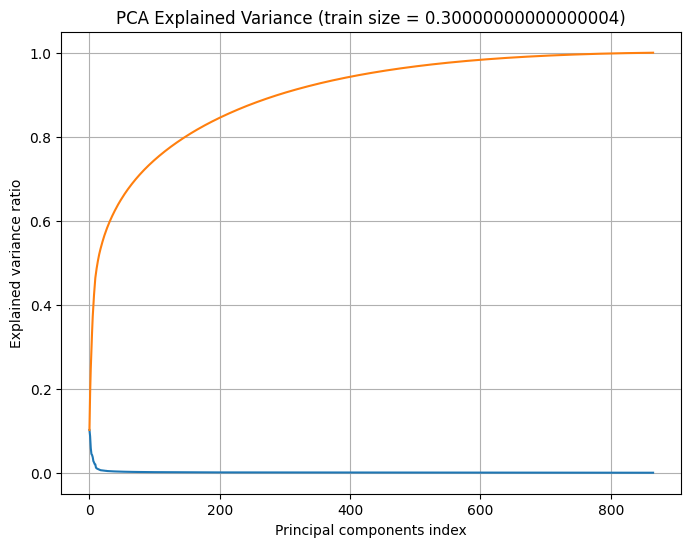



 ---------- TEST SIZE = 0.7 | MILSABEL PERCENTAGE = 0 ---------- 


grid_search.best_params_:  {'estimator__n_neighbors': 3, 'pca__n_components': 30}
grid_search.best_score_:  0.9692429193899782


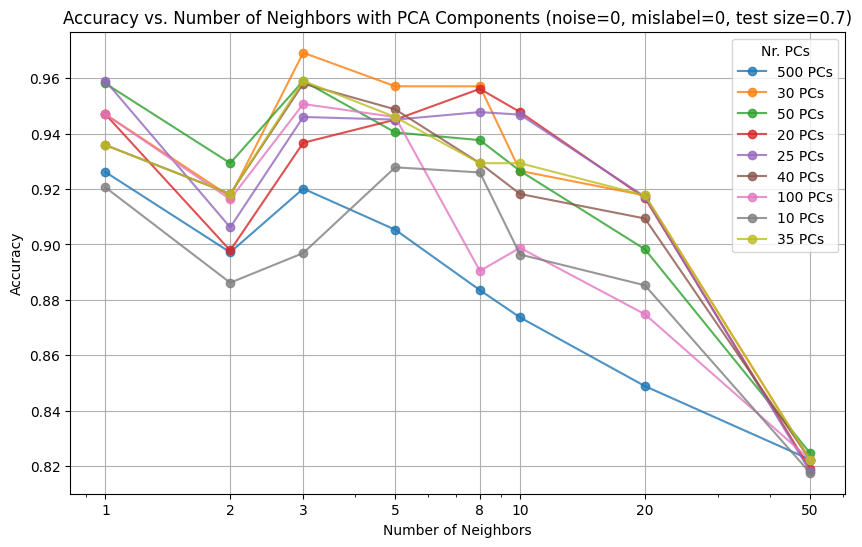

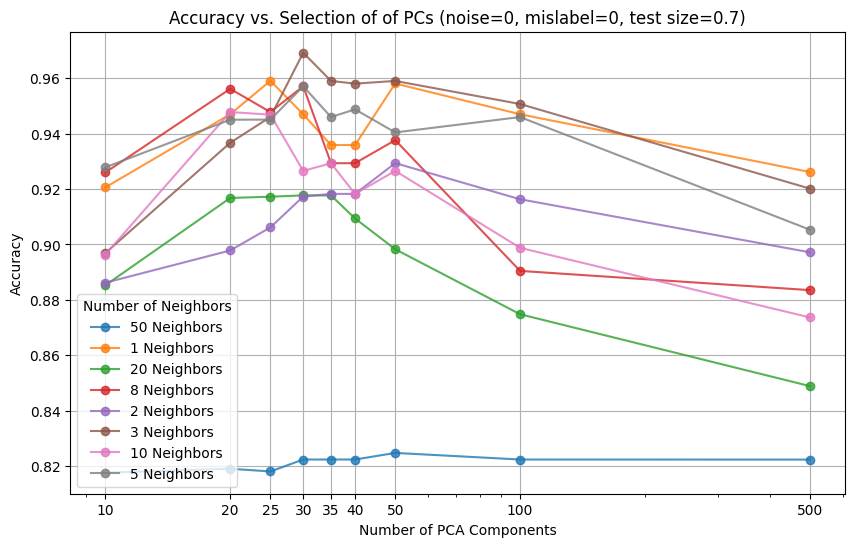

grid_search.best_params_:  {'estimator__n_neighbors': 5, 'kbest__k': 100, 'kbest__score_func': <function f_classif at 0x000002B93C02ECA0>}
grid_search.best_score_:  0.9633169934640524


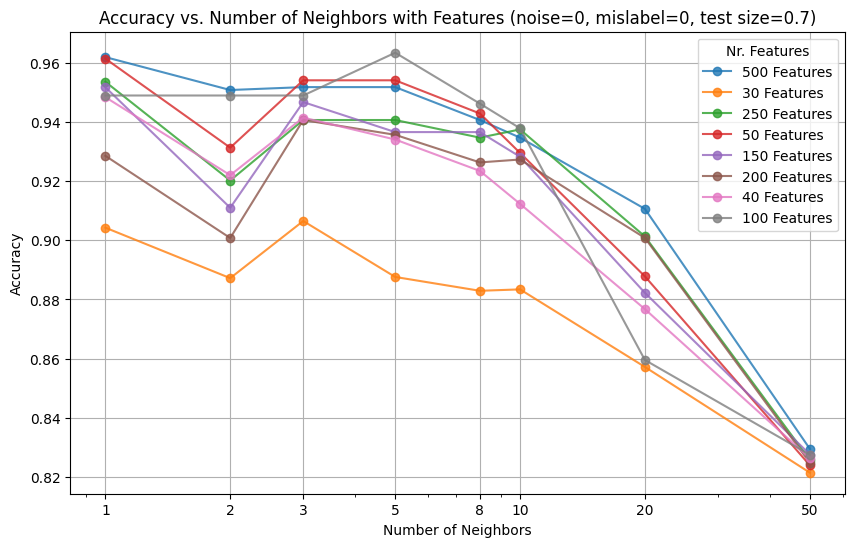

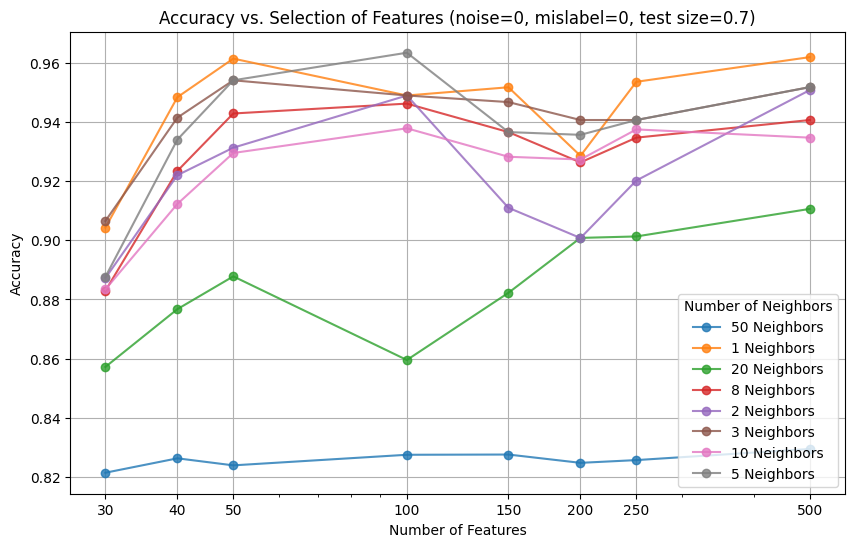

Best training k: 1
Best training score: 1.0


 ALL CV SCORES

 [0.92063072 0.9470207  0.9591122  0.9470207  0.93590959 0.93590959
 0.95813181 0.9470207  0.92616091 0.88618904 0.89783769 0.90617102
 0.91731015 0.91826253 0.91826253 0.92937364 0.91632975 0.89717126
 0.89691068 0.93672658 0.94604031 0.96924292 0.95905773 0.95807734
 0.95905773 0.9507244  0.92016885 0.92786839 0.94505991 0.94508792
 0.95712496 0.94601385 0.94879163 0.94045829 0.94601385 0.90532758
 0.92600385 0.95619904 0.94781124 0.95712496 0.92934718 0.92934718
 0.93768052 0.89045829 0.88351385 0.89636788 0.94781124 0.94688531
 0.92656941 0.92934718 0.91823607 0.92656941 0.89879163 0.87365274
 0.88525677 0.91679272 0.91725568 0.91771864 0.91771864 0.90938531
 0.8982742  0.87481015 0.84885777 0.81757793 0.81901494 0.81803455
 0.82234827 0.82234827 0.82234827 0.82472923 0.82234827 0.82232182]
For k=1 and PCA components=25, CV Score: 0.9591122004357299, Test Score: 0.9828339911069343, Train Score: 1.0
For k=2 and PCA compon

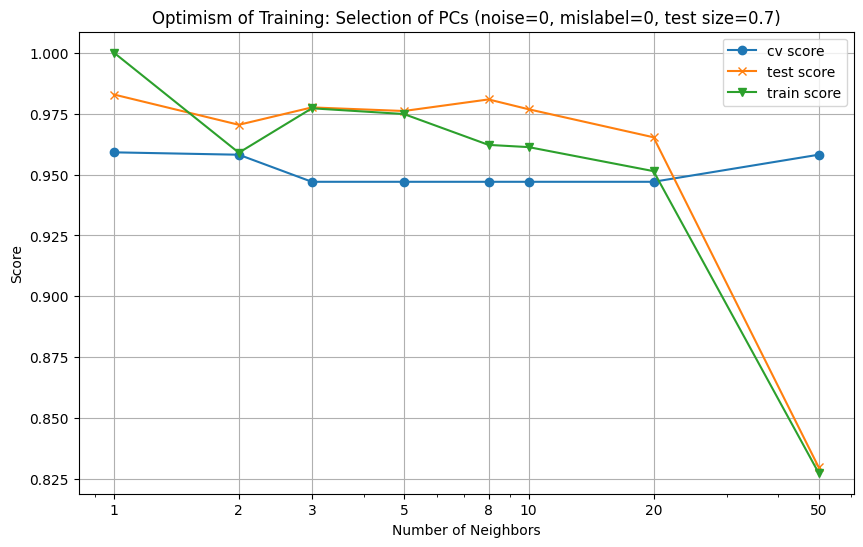

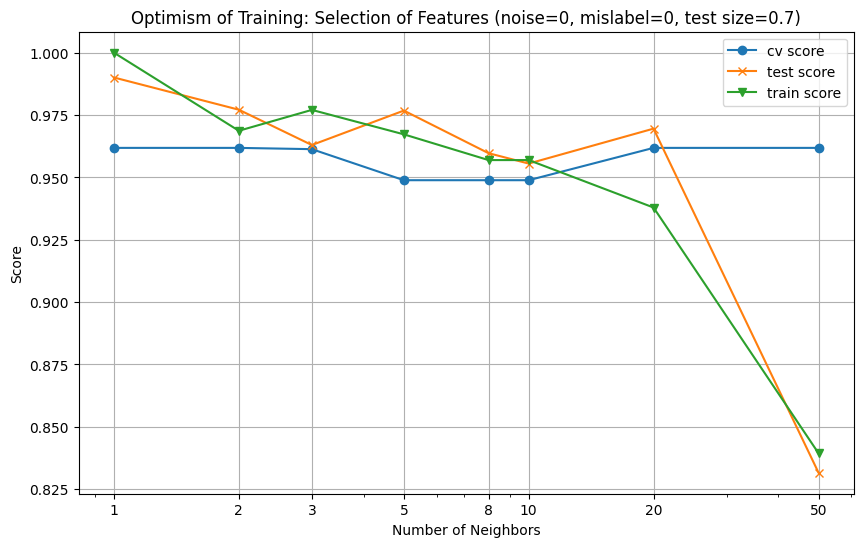



 ---------- TEST SIZE = 0.7 | MILSABEL PERCENTAGE = 0.2 ---------- 




In [22]:
main()